# Classification of Damage in FEM Model Pipes

This program reads the data from a number of damaged state trials of both finite element models (FEMs) and physical experiments. 
The database of model results is populated by the original signal responses from the model for a number of transducer array locations. The program generates white noise of user-specified properties and time-averages the the noisy responses.
The database of physical experimental results is populated by signal responses picked up by a bus-powered USB. Environmental white noise is a natural inclusion of the signal in this case; therefore a number of trace responses are populated into the database for time-averaging.
All of the trials are marked by their states of damage, and the type of damage variation is specified by the user. Principal Component Analysis (PCA) is used to reduce the dimensionality of the data and clearly present the relation of the damaged state with the PCs. Machine Learning via Support Vector Machines (SVM) is used to determine the optimal number of PCs. It may also be used to classify the data through application of feature extraction methods.

## User Inputs

All of the data is stored in an excel file in which waveguide material properties, crack geometry, FEM mesh, transducer specifications, and other such parameters are identified for each signal. The signals in this file have a sampling frequency of 100 kSa/s and duration of 5 ms. Specify this excel file under filename.

In [532]:
# Stored Data
filename = 'G:/My Drive/USGW Research/Programming/Git Practice/Ultrasonic-Guided-Waves-in-Polyethylene-Pipes/Signals.xlsx'

# Parameters
Pipe_model     = 'Comsol 6.0 Model'
Pipe_physical  = 'Pipe 4'

# Material Properties
Elasticity          = 'Viscoelastic'
Modulus             = 1.1      # GPa
Poissons            = 0.45     # microstrains/microstrains
Density             = 1125     # kg/m^3
ShearAttenuation    = 70       # dB/m
PressureAttenuation = 30       # dB/m

# Crack Geometry
Orientation   = 90;      # degrees
Location      = 235;     # mm
Depth         = 21;      # mm
Length        = 2*Depth; # mm
Width         = 2;       # mm
Circumference = 'Outside'

# Mesh
meshmax     = 15;      # mm
meshmin     = 0.5;     # mm
timestep    = 0.005;   # ms

# Transducers
StrainCoefficient = 'd33'
PZTType_model     = 'Point'
PZTType_physical  = 'Piezo-Disc'
Arrays            = ['A','A\'','R\'','R'];
Axes              = [2,4];
Amount            = 28;

# Signal
Amplitude = 2e-4;
Frequency = 10000;
Cycles    = 5;

# Artificially generated white noise
mean    = 0;
std     = 5e-4;
SNR_dB  = 35               # Desired SNR in decibels

# All variables are frozen except one
category = 'Pipe'
variable = 'Density (kg per m^3)'

# Storage of Analysis Results
parent    = 'G:/My Drive/USGW Research/Programming/Git Practice/Ultrasonic-Guided-Waves-in-Polyethylene-Pipes'
# directory = 'Depth Damaged States Attenuation Model - Orientation =  ' + str(Orientation) + ', Width = ' + str(Width) + ', Circumference = ' + str(Circumference) + ', Axial Location = ' + str(Location)
directory = 'Varying ' + variable

## Import Necessary Modules and Functions

In [533]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import math
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
import pickle
from PIL import Image
import scipy as sp
import scipy.fftpack as fft
from scipy.fft import fft, ifft
from scipy import signal
import pywt
# install lvm-read

Add text and color:

In [534]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

Obtain the frequency domains of all the signals in the dataframe in the form of the Single-Sided Amplitude Spectrums:

In [535]:
def ssas (Fs, time_domain):
    (L,n) = np.shape(time_domain)                # size of the time domain database (number of signals x number of samples)
    T = 1/Fs                                     # Sampling period
    t = np.arange(0,duration+T,T)                # zeroed time axis in seconds
    
    # Power Spectrum
    Y = []
    i = 0
    for index, row in time_domain.iterrows():
        Y.append(fft(row.values))
        i = i + 1
        
    # Normalized magnitude of the power spectrum
    P2 = []
    P1 = []
    i = 0

    while i < L:
        p2                   = abs(Y[i]);              # Double-sided Amplitude Spectrum
        p1                   = p2[0:math.ceil(n/2)];
        p1[1:math.ceil(n/2)] = 2*p1[1:math.ceil(n/2)]; # Single-sided Amplitude Spectrum
        i = i + 1;

        P2.append(p2)
        P1.append(p1)
    
    # Frequency domain dataframe
    f = Fs*list(range(0,math.ceil(n/2)))/n;     # Frequency Axis
    P1 = pd.DataFrame(P1)
    freq_dom_title = []
    for freq in f:
        freq_dom_title.append('Frequency Domain (Hz)')

    header = [freq_dom_title, f]
    P1 = pd.DataFrame(P1)
    P1.columns = header
    
    return P1

Plot all frequency domains on the same grid and color-vode them by damaged state:

In [536]:
def freq_domains_by_ds(freq_bins, colors_dict, transparency, df, grouping_category, title):
    
    # freq_bins is a list of floats, colors_dict is a dictionary with ints for keys and colors string for items, 
    # transparency is a float, df is a pandas dataframe, and grouping_category is a string
    
    # df has frequency attributes that may be extracted using extract_freq_bins
    
#     plt.axis('on')
    fig, ax = plt.subplots(figsize = (15,10))

    grouped = df.groupby(grouping_category)

    for freq in freq_bins:
        x1 = np.ones(len(df.index))
        x1 = x1*freq
        df['Frequency (Hz)'] = x1
        for key, group in grouped:
            group.plot(ax=ax, kind='scatter', x=freq, y=df[freq], alpha = transparency, color=colors[key])
    
    plt.legend(colors_dict.keys());
    ax.set_ylabel('Single Sided Amplitude Spectrum', fontsize = 15)
    ax.set_xlabel('Frequency (Hz)', fontsize = 15)    
    ax.set_title(title, fontsize = 20)
#     fig.suptitle('Frequency Domain Response by Damaged State',fontsize = 15)
    plt.grid(which='major', linestyle='-')    
    plt.show()
    
#     df = df.drop('Frequency (Hz)', axis=1)
        
    return fig, ax

Run a preliminary PCA which reduces the dataset from a high-order number of variables to 2 PCs. This function provides the explained variance, plots the components on a coordinate grid, and presents teh expleained variance vs number of components:

In [537]:
def prePCA (freq_data):
    pca = RandomizedPCA(n_components=2)
    pca.fit(freq_data)
    freq_data_pca = pca.transform(freq_data)
    print("original shape:   ", freq_data.shape)
    print("transformed shape:", freq_data_pca.shape)
    label = "Variance explained by each principal component \nPC1: " + str(pca.explained_variance_ratio_[0]) + ' \nPC2: '+ str(pca.explained_variance_ratio_[1])
    print(label)
    
    fig, ax = plt.subplots(2,figsize=(10,10))
    
    comps = pca.components_
    ax[0].scatter(freq_data_pca[:,0],freq_data_pca[:,1])
    ax[0].set_xlabel('Component 1')
    ax[0].set_ylabel('Component 2');
    
    pca = RandomizedPCA().fit(freq_data)
    ax[1].plot(np.cumsum(pca.explained_variance_ratio_))
    ax[1].set_xlabel('Number of components')
    ax[1].set_ylabel('Cumulative explained variance');
    
    ax[1].text(0, 1, label)
    
    return pca, comps, freq_data_pca

Categorize train and test data using SVM. This code uses the grid-search method to optimize the number of PCs. Hyperparameter tuning is employed to run multiple trials and compare accuracies to a subset of trained data.

In [538]:
def pca_svm (n_components):
    pca = RandomizedPCA(n_components)
    pca.fit(x)
    # pca.transform(x)
    svc = SVC(kernel='rbf')
    basemodel = make_pipeline(pca, svc)
    
    param_grid = {'svc__C': np.logspace(np.log10(0.001), np.log10(20), num=200),
                  'svc__gamma': ['auto']}
    grid = GridSearchCV(basemodel, param_grid, cv = 5, n_jobs = 2, verbose = 0)
    lab_enc = preprocessing.LabelEncoder()
    ytrain_encoded = lab_enc.fit_transform(ytrain)
    ytest_encoded = lab_enc.fit_transform(ytest)
    grid.fit(Xtrain, ytrain_encoded)

    svc_model = grid.best_estimator_
    yfit = svc_model.predict(Xtest)
    classification = classification_report(ytest_encoded, yfit)
    accuacy = accuracy_score(ytest_encoded, yfit)
    
    freq_data_pca = pca.transform(x)
    return classification, accuacy, freq_data_pca, svc_model

This is the testing dataset's accuracy. To get the training dataset's accuracy, just replace Xtest with Xtrain. We're expecting testing accuracy to be lower if we have a much bigger starting database size, but in this case both the testing and training data accuracies are good characterizations of the model's accuracy. If both datasets provide a good accuracy, overfitting may not be a problem.

## Point to Directory

In [539]:
cwd = os.getcwd
print(os.getcwd())

G:\My Drive\USGW Research\Programming\Git Practice\Ultrasonic-Guided-Waves-in-Polyethylene-Pipes


In [540]:
os.chdir(parent)

## Initialize Data Matrices

The user-specified filepath above must be .xlsx

The data incorporated within the database includes interval data representing the time-domains of the response signals, the single-sided amplitude spectrum over a specified frequency range, details on the transducers and crack orientations, information on the pipe and geometries, and other such data.

In [541]:
sheetname = '10 kHz 100 kSa-s 5 ms'
damage    = pd.read_excel(filename, sheetname, header = [0,1]);
damage.head(10)

Pipe                                           \
         Designation Elasticity Modulus (GPa) Poisson's Ratio   
0  Comsol 5.3a Model    Elastic           1.1            0.45   
1  Comsol 5.3a Model    Elastic           1.1            0.45   
2  Comsol 5.3a Model    Elastic           1.1            0.45   
3  Comsol 5.3a Model    Elastic           1.1            0.45   
4  Comsol 5.3a Model    Elastic           1.1            0.45   
5  Comsol 5.3a Model    Elastic           1.1            0.45   
6  Comsol 5.3a Model    Elastic           1.1            0.45   
7  Comsol 5.3a Model    Elastic           1.1            0.45   
8  Comsol 5.3a Model    Elastic           1.1            0.45   
9  Comsol 5.3a Model    Elastic           1.1            0.45   

                                                     \
  Density (kg per m^3) Shear Attenuation (dB per m)   
0                  945                            -   
1                  945                            -   
2                  945                            -   
3                  945                            -   
4                  945                            -   
5                  945                            -   
6                  945                            -   
7                  945                            -   
8                  945                            -   
9                  945                            -   

                                   Transducer                        ...  \
  Pressure Attenuation (dB per m) Designation Axis Amount per Array  ...   
0                               -           A  1.0              NaN  ...   
1                               -           A  2.0              NaN  ...   
2                               -           A  3.0              NaN  ...   
3                               -           A  4.0              NaN  ...   
4                               -           A  1.5              NaN  ...   
5                               -           A  2.5              NaN  ...   
6                               -           A  3.5              NaN  ...   
7                               -           A  4.5              NaN  ...   
8                               -          A'  1.0              NaN  ...   
9                               -          A'  2.0              NaN  ...   

  Time Domain (ms)                                                    \
              4.94      4.95      4.96      4.97      4.98      4.99   
0        -0.000208 -0.000116  0.000047  0.000227  0.000362  0.000408   
1        -0.000035  0.000072  0.000186  0.000278  0.000320  0.000297   
2        -0.000214 -0.000083  0.000089  0.000242  0.000323  0.000309   
3        -0.000396 -0.000343 -0.000144  0.000122  0.000352  0.000463   
4        -0.003529 -0.002902  0.001397  0.000892  0.002835  0.004254   
5        -0.003550 -0.002944 -0.001379  0.000761  0.002819  0.004252   
6        -0.003457 -0.002660 -0.001025  0.001021  0.002886  0.004062   
7        -0.003512 -0.002713  0.001083  0.001013  0.002901  0.004108   
8        -0.010845  0.002548  0.014823  0.021428  0.020023  0.011392   
9        -0.011807  0.001015  0.013210  0.020338  0.019946  0.012490   

                         
          5 5.1 5.2 5.3  
0  0.000352 NaN NaN NaN  
1  0.000208 NaN NaN NaN  
2  0.000209 NaN NaN NaN  
3  0.000422 NaN NaN NaN  
4  0.004648 NaN NaN NaN  
5  0.004644 NaN NaN NaN  
6  0.004225 NaN NaN NaN  
7  0.004268 NaN NaN NaN  
8 -0.000907 NaN NaN NaN  
9  0.001093 NaN NaN NaN  

[10 rows x 530 columns]

In [542]:
damage

Pipe                                              \
             Designation    Elasticity Modulus (GPa) Poisson's Ratio   
0      Comsol 5.3a Model       Elastic           1.1            0.45   
1      Comsol 5.3a Model       Elastic           1.1            0.45   
2      Comsol 5.3a Model       Elastic           1.1            0.45   
3      Comsol 5.3a Model       Elastic           1.1            0.45   
4      Comsol 5.3a Model       Elastic           1.1            0.45   
...                  ...           ...           ...             ...   
10383   Comsol 6.0 Model  Viscoelastic           1.1            0.45   
10384   Comsol 6.0 Model  Viscoelastic           1.1            0.45   
10385   Comsol 6.0 Model  Viscoelastic           1.1            0.45   
10386   Comsol 6.0 Model  Viscoelastic           1.1            0.45   
10387   Comsol 6.0 Model  Viscoelastic           1.1            0.45   

                                                         \
      Density (kg per m^3) Shear Attenuation (dB per m)   
0                      945                            -   
1                      945                            -   
2                      945                            -   
3                      945                            -   
4                      945                            -   
...                    ...                          ...   
10383                 1125                           75   
10384                 1125                           75   
10385                 1125                           75   
10386                 1125                           75   
10387                 1125                           75   

                                       Transducer                        ...  \
      Pressure Attenuation (dB per m) Designation Axis Amount per Array  ...   
0                                   -           A  1.0              NaN  ...   
1                                   -           A  2.0              NaN  ...   
2                                   -           A  3.0              NaN  ...   
3                                   -           A  4.0              NaN  ...   
4                                   -           A  1.5              NaN  ...   
...                               ...         ...  ...              ...  ...   
10383                              30           R  4.0             28.0  ...   
10384                              30           R  1.5             28.0  ...   
10385                              30           R  2.5             28.0  ...   
10386                              30           R  3.5             28.0  ...   
10387                              30           R  4.5             28.0  ...   

      Time Domain (ms)                                                    \
                  4.94      4.95      4.96      4.97      4.98      4.99   
0            -0.000208 -0.000116  0.000047  0.000227  0.000362  0.000408   
1            -0.000035  0.000072  0.000186  0.000278  0.000320  0.000297   
2            -0.000214 -0.000083  0.000089  0.000242  0.000323  0.000309   
3            -0.000396 -0.000343 -0.000144  0.000122  0.000352  0.000463   
4            -0.003529 -0.002902  0.001397  0.000892  0.002835  0.004254   
...                ...       ...       ...       ...       ...       ...   
10383         0.000043  0.000042  0.000040  0.000037  0.000034  0.000030   
10384         0.000086  0.000083  0.000077  0.000069 -0.000060 -0.000048   
10385        -0.000072 -0.000071 -0.000069 -0.000064 -0.000057 -0.000048   
10386        -0.000091 -0.000083 -0.000073 -0.000060 -0.000047 -0.000035   
10387         0.000094  0.000084  0.000072  0.000059  0.000045  0.000032   

                             
              5 5.1 5.2 5.3  
0      0.000352 NaN NaN NaN  
1      0.000208 NaN NaN NaN  
2      0.000209 NaN NaN NaN  
3      0.000422 NaN NaN NaN  
4      0.004648 NaN NaN NaN  
...         ...  ..  ..  ..  
10383  0.000025 NaN NaN NaN  
10384 -0.000036

Extract the signal's discrete time axis:

In [543]:
time = np.array(damage['Time Domain (ms)'].columns)

Zoom in only on one part of the time domain (0-3 ms in this case)

In [544]:
for timestamp in time:
    if (float(timestamp) >= 3.00):
        # print(timestamp in damage['Time Domain (ms)'].columns)
        damage = damage.drop(timestamp, axis=1, level = 1)

time = np.array(damage['Time Domain (ms)'].columns)

np.shape(damage)

(10388, 326)

## Data Processing

Elaborate definiations for visualization:

In [545]:
if StrainCoefficient == 'd33':
    disps = 'Radial Displacements'
elif StrainCoefficient == 'd31':
    disps = 'Axial Displacements'

### Parameter Dictionaries

In [546]:
mat_props = {}

mat_props['Elasticity']                      = Elasticity;
mat_props['Modulus (GPa)']                   = Modulus;
mat_props['Poisson\'s Ratio']                = Poissons;
mat_props['Density (kg per m^3)']            = Density;
mat_props['Shear Attenuation (dB per m)']    = ShearAttenuation;
mat_props['Pressure Attenuation (dB per m)'] = PressureAttenuation;

mat_props

{'Elasticity': 'Viscoelastic',
 'Modulus (GPa)': 1.1,
 "Poisson's Ratio": 0.45,
 'Density (kg per m^3)': 1125,
 'Shear Attenuation (dB per m)': 70,
 'Pressure Attenuation (dB per m)': 30}

In [547]:
crack_geom = {}

crack_geom['Circumference']         = Circumference;
crack_geom['Axial Location (mm)']   = Location;
crack_geom['Orientation (degrees)'] = Orientation;
crack_geom['Depth (mm)']            = Depth;
crack_geom['Length (mm)']           = Length;
crack_geom['Thickness (mm)']        = Width;

crack_geom

{'Circumference': 'Outside',
 'Axial Location (mm)': 235,
 'Orientation (degrees)': 90,
 'Depth (mm)': 21,
 'Length (mm)': 42,
 'Thickness (mm)': 2}

In [548]:
transducer = {}

transducer['Strain Coefficient'] = StrainCoefficient
transducer['Model Type']         = PZTType_model
transducer['Physical Type']      = PZTType_physical
transducer['Amount per Array']   = Amount

transducer

{'Strain Coefficient': 'd33',
 'Model Type': 'Point',
 'Physical Type': 'Piezo-Disc',
 'Amount per Array': 28}

In [549]:
intervals = {}

intervals['Max Edge Length (mm)'] = meshmax
intervals['Min Edge Length (mm)'] = meshmin
intervals['Time Step (ms)']       = timestep

intervals

{'Max Edge Length (mm)': 15,
 'Min Edge Length (mm)': 0.5,
 'Time Step (ms)': 0.005}

In [550]:
signal_props = {}

signal_props['Amplitude (VPP)'] = Amplitude
signal_props['Frequency (Hz)']  = Frequency
signal_props['Cycles']          = Cycles

signal_props

{'Amplitude (VPP)': 0.0002, 'Frequency (Hz)': 10000, 'Cycles': 5}

In [551]:
'Amplitude (VPP)' in signal_props.keys()

True

### Boolean Markers

In [552]:
mat_props_params  = list(mat_props.keys())
crack_geom_params = list(crack_geom.keys())
intervals_params  = list(intervals.keys())
signal_params     = list(signal_props.keys())

In [553]:
is_pipe       = damage['Pipe','Designation']               == Pipe_model
is_sc         = damage['Transducer','Strain Coefficient']  == StrainCoefficient
is_pzttype    = damage['Transducer','PZT Type']            == PZTType_model

### Undamaged State

The undamaged state sees no variability in the parameters simply because it's a single state. Therefore, highlight this state by specifying no crack and the user-defined material, ultrasonic, and interval paramters above.

In [554]:
is_undamaged  = damage['Crack Properties','Depth (mm)']   == 0; # ie no crack

undamaged = damage[is_pipe & is_sc & is_pzttype]
undamaged = undamaged[is_undamaged]

if variable in mat_props_params:
    mat_props_params.remove(variable)
    
if variable in signal_params:
    signal_params.remove(variable)

for param in mat_props_params:
    undamaged = undamaged[undamaged['Pipe',param] == mat_props[param]]

for param in intervals_params:    
    undamaged = undamaged[undamaged['Mesh',param] == intervals[param]]
    
for param in signal_params:
    undamaged = undamaged[undamaged['Signal',param] == signal_props[param]]
    
undamaged = undamaged[undamaged['Transducer','Amount per Array'] == Amount]
    
undamaged

C:\Users\WEISUN~1\AppData\Local\Temp/ipykernel_17908/2907669362.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  undamaged = undamaged[is_undamaged]


Pipe                                              \
            Designation    Elasticity Modulus (GPa) Poisson's Ratio   
8372   Comsol 6.0 Model  Viscoelastic           1.1            0.45   
8373   Comsol 6.0 Model  Viscoelastic           1.1            0.45   
8374   Comsol 6.0 Model  Viscoelastic           1.1            0.45   
8375   Comsol 6.0 Model  Viscoelastic           1.1            0.45   
8376   Comsol 6.0 Model  Viscoelastic           1.1            0.45   
...                 ...           ...           ...             ...   
10031  Comsol 6.0 Model  Viscoelastic           1.1            0.45   
10032  Comsol 6.0 Model  Viscoelastic           1.1            0.45   
10033  Comsol 6.0 Model  Viscoelastic           1.1            0.45   
10034  Comsol 6.0 Model  Viscoelastic           1.1            0.45   
10035  Comsol 6.0 Model  Viscoelastic           1.1            0.45   

                                                         \
      Density (kg per m^3) Shear Attenuation (dB per m)   
8372                   945                           70   
8373                   945                           70   
8374                   945                           70   
8375                   945                           70   
8376                   945                           70   
...                    ...                          ...   
10031                 1125                           70   
10032                 1125                           70   
10033                 1125                           70   
10034                 1125                           70   
10035                 1125                           70   

                                       Transducer                        ...  \
      Pressure Attenuation (dB per m) Designation Axis Amount per Array  ...   
8372                               30           A  1.0             28.0  ...   
8373                               30           A  2.0             28.0  ...   
8374                               30           A  3.0             28.0  ...   
8375                               30           A  4.0             28.0  ...   
8376                               30           A  1.5             28.0  ...   
...                               ...         ...  ...              ...  ...   
10031                              30           R  4.0             28.0  ...   
10032                              30           R  1.5             28.0  ...   
10033                              30           R  2.5             28.0  ...   
10034                              30           R  3.5             28.0  ...   
10035                              30           R  4.5             28.0  ...   

      Time Domain (ms)                                                        \
                   2.9          2.91      2.92      2.93      2.94      2.95   
8372         -0.000062 -7.592100e-05 -0.000087 -0.000096 -0.000101 -0.000103   
8373         -0.000048 -6.226100e-05 -0.000075 -0.000084 -0.000091 -0.000095   
8374         -0.000047 -6.083400e-05 -0.000073 -0.000082 -0.000088 -0.000092   
8375         -0.000059 -7.236700e-05 -0.000083 -0.000091 -0.000096 -0.000097   
8376          0.000054 -5.028700e-05 -0.000124 -0.000198 -0.000265 -0.000322   
...                ...           ...       ...       ...       ...       ...   
10031         0.000004  6.768400e-07 -0.000002 -0.000005 -0.000006 -0.000007   
10032        -0.000046 -5.052600e-05 -0.000054 -0.000056 -0.000056 -0.000054   
10033         0.000042  4.718000e-05  0.000052  0.000054 -0.000055 -0.000054   
10034         0.000054  5.826400e-05  0.000061  0.000062  0.000061 -0.000057   
10035        -0.000056 -6.049600e-05 -0.000063 -0.000064 -0.000062  0.000058   

                                               
           2.96      2.97      2.98      2.99  
8372  -0.000101 -0.000096 -0.000087 -0.000076  
8373  -0.000095 -0.000092 -0.000086 -0.000078  
8374  -0.000092 -0.000089 -0.000083 -0.000075  
8375 

In [555]:
undamaged['Signal','Amplitude (VPP)'].unique()

array([0.0002])

### Damaged States at the Variablity of a Single Parameter

Highlight the damaged states of interest by specifying the user-defined crack geometry, material, ultrasonic, and interval parameters above. Everything is frozen except the parameter of interest.

Exception: If the parameter of interest is the crack depth, then the crack length is also variable and vice-versa. It's unrealistic to expect that one would vary and not the other in a real-world damage scenario.

In [556]:
damaged = damage[is_pipe & is_sc & is_pzttype]

if variable in mat_props_params:
    mat_props_params.remove(variable)
    
elif variable in crack_geom_params:
    crack_geom_params.remove(variable)
    if variable == 'Depth (mm)':
        crack_geom_params.remove('Length (mm)')
        
elif variable in intervals_params:
    intervals_params.remove(variable)

for param in mat_props_params:
    damaged = damaged[damaged['Pipe',param] == mat_props[param]]

for param in crack_geom_params:
    damaged = damaged[damaged['Crack Properties',param] == crack_geom[param]]

for param in intervals_params:    
    damaged = damaged[damaged['Mesh',param] == intervals[param]]
    
for param in signal_props:
    damaged = damaged[damaged['Signal',param] == signal_props[param]]
    
damaged = damaged[damaged['Transducer','Amount per Array'] == Amount]

damaged

Empty DataFrame
Columns: [(Pipe, Designation), (Pipe, Elasticity), (Pipe, Modulus (GPa)), (Pipe, Poisson's Ratio), (Pipe, Density (kg per m^3)), (Pipe, Shear Attenuation (dB per m)), (Pipe, Pressure Attenuation (dB per m)), (Transducer, Designation), (Transducer, Axis), (Transducer, Amount per Array), (Transducer, Strain Coefficient), (Transducer, PZT Type), (Signal, Amplitude (VPP)), (Signal, Frequency (Hz)), (Signal, Sampling Rate (Sa/s)), (Signal, Cycles), (Mesh, Max Edge Length (mm)), (Mesh, Min Edge Length (mm)), (Mesh, Time Step (ms)), (Crack Properties, Order), (Crack Properties, Circumference), (Crack Properties, Orientation (degrees)), (Crack Properties, Axial Location (mm)), (Crack Properties, Thickness (mm)), (Crack Properties, Depth (mm)), (Crack Properties, Length (mm)), (Time Domain (ms), 0), (Time Domain (ms), 0.01), (Time Domain (ms), 0.02), (Time Domain (ms), 0.03), (Time Domain (ms), 0.04), (Time Domain (ms), 0.05), (Time Domain (ms), 0.06), (Time Domain (ms), 0.07), (Time Domain (ms), 0.08), (Time Domain (ms), 0.09), (Time Domain (ms), 0.1), (Time Domain (ms), 0.11), (Time Domain (ms), 0.12), (Time Domain (ms), 0.13), (Time Domain (ms), 0.14), (Time Domain (ms), 0.15), (Time Domain (ms), 0.16), (Time Domain (ms), 0.17), (Time Domain (ms), 0.18), (Time Domain (ms), 0.19), (Time Domain (ms), 0.2), (Time Domain (ms), 0.21), (Time Domain (ms), 0.22), (Time Domain (ms), 0.23), (Time Domain (ms), 0.24), (Time Domain (ms), 0.25), (Time Domain (ms), 0.26), (Time Domain (ms), 0.27), (Time Domain (ms), 0.28), (Time Domain (ms), 0.29), (Time Domain (ms), 0.3), (Time Domain (ms), 0.31), (Time Domain (ms), 0.32), (Time Domain (ms), 0.33), (Time Domain (ms), 0.34), (Time Domain (ms), 0.35), (Time Domain (ms), 0.36), (Time Domain (ms), 0.37), (Time Domain (ms), 0.38), (Time Domain (ms), 0.39), (Time Domain (ms), 0.4), (Time Domain (ms), 0.41), (Time Domain (ms), 0.42), (Time Domain (ms), 0.43), (Time Domain (ms), 0.44), (Time Domain (ms), 0.45), (Time Domain (ms), 0.46), (Time Domain (ms), 0.47), (Time Domain (ms), 0.48), (Time Domain (ms), 0.49), (Time Domain (ms), 0.5), (Time Domain (ms), 0.51), (Time Domain (ms), 0.52), (Time Domain (ms), 0.53), (Time Domain (ms), 0.54), (Time Domain (ms), 0.55), (Time Domain (ms), 0.56), (Time Domain (ms), 0.57), (Time Domain (ms), 0.58), (Time Domain (ms), 0.59), (Time Domain (ms), 0.6), (Time Domain (ms), 0.61), (Time Domain (ms), 0.62), (Time Domain (ms), 0.63), (Time Domain (ms), 0.64), (Time Domain (ms), 0.65), (Time Domain (ms), 0.66), (Time Domain (ms), 0.67), (Time Domain (ms), 0.68), (Time Domain (ms), 0.69), (Time Domain (ms), 0.7), (Time Domain (ms), 0.71), (Time Domain (ms), 0.72), (Time Domain (ms), 0.73), ...]
Index: []

[0 rows x 326 columns]

Combine the undamaged and damaged dataframes into a single dataframe. Sort the rows of the database so that the data is populated in ascending order of damaged state. Undamaged is first.

In [557]:
undamaged   = undamaged.replace({'-': -1}, regex = True)

if variable in mat_props.keys():
    damaged = damaged.sort_values(by=[('Pipe',variable)])
elif variable in crack_geom.keys():
    damaged = damaged.sort_values(by=[('Crack Properties',variable)])
elif variable in intervals.keys():
    damaged = damaged.sort_values(by=[('Mesh',variable)])
# damaged     = damaged.sort_values(by=[('Crack Properties',variable)])

this_damage = pd.concat([undamaged,damaged])

this_damage = this_damage.replace({-1: '-'}, regex = True)

this_damage

Pipe                                              \
            Designation    Elasticity Modulus (GPa) Poisson's Ratio   
8372   Comsol 6.0 Model  Viscoelastic           1.1            0.45   
8373   Comsol 6.0 Model  Viscoelastic           1.1            0.45   
8374   Comsol 6.0 Model  Viscoelastic           1.1            0.45   
8375   Comsol 6.0 Model  Viscoelastic           1.1            0.45   
8376   Comsol 6.0 Model  Viscoelastic           1.1            0.45   
...                 ...           ...           ...             ...   
10031  Comsol 6.0 Model  Viscoelastic           1.1            0.45   
10032  Comsol 6.0 Model  Viscoelastic           1.1            0.45   
10033  Comsol 6.0 Model  Viscoelastic           1.1            0.45   
10034  Comsol 6.0 Model  Viscoelastic           1.1            0.45   
10035  Comsol 6.0 Model  Viscoelastic           1.1            0.45   

                                                         \
      Density (kg per m^3) Shear Attenuation (dB per m)   
8372                   945                           70   
8373                   945                           70   
8374                   945                           70   
8375                   945                           70   
8376                   945                           70   
...                    ...                          ...   
10031                 1125                           70   
10032                 1125                           70   
10033                 1125                           70   
10034                 1125                           70   
10035                 1125                           70   

                                       Transducer                        ...  \
      Pressure Attenuation (dB per m) Designation Axis Amount per Array  ...   
8372                               30           A  1.0             28.0  ...   
8373                               30           A  2.0             28.0  ...   
8374                               30           A  3.0             28.0  ...   
8375                               30           A  4.0             28.0  ...   
8376                               30           A  1.5             28.0  ...   
...                               ...         ...  ...              ...  ...   
10031                              30           R  4.0             28.0  ...   
10032                              30           R  1.5             28.0  ...   
10033                              30           R  2.5             28.0  ...   
10034                              30           R  3.5             28.0  ...   
10035                              30           R  4.5             28.0  ...   

      Time Domain (ms)                                                        \
                   2.9          2.91      2.92      2.93      2.94      2.95   
8372         -0.000062 -7.592100e-05 -0.000087 -0.000096 -0.000101 -0.000103   
8373         -0.000048 -6.226100e-05 -0.000075 -0.000084 -0.000091 -0.000095   
8374         -0.000047 -6.083400e-05 -0.000073 -0.000082 -0.000088 -0.000092   
8375         -0.000059 -7.236700e-05 -0.000083 -0.000091 -0.000096 -0.000097   
8376          0.000054 -5.028700e-05 -0.000124 -0.000198 -0.000265 -0.000322   
...                ...           ...       ...       ...       ...       ...   
10031         0.000004  6.768400e-07 -0.000002 -0.000005 -0.000006 -0.000007   
10032        -0.000046 -5.052600e-05 -0.000054 -0.000056 -0.000056 -0.000054   
10033         0.000042  4.718000e-05  0.000052  0.000054 -0.000055 -0.000054   
10034         0.000054  5.826400e-05  0.000061  0.000062  0.000061 -0.000057   
10035        -0.000056 -6.049600e-05 -0.000063 -0.000064 -0.000062  0.000058   

                                               
           2.96      2.97      2.98      2.99  
8372  -0.000101 -0.000096 -0.000087 -0.000076  
8373  -0.000095 -0.000092 -0.000086 -0.000078  
8374  -0.000092 -0.000089 -0.000083 -0.000075  
8375 

### Single-Sided Amplitude Spectrums

In [558]:
duration = (time.transpose()[-1] - time.transpose()[0])/1000;   # total duration of signal (s)
n = len(time.transpose());                                      # total number of samples in signal (Sa)
Fs = np.array((n-1)/duration);                                  # sampling frequency of signal (Sa/s)
T  = 1/Fs;                                                      # sampling period (s)

(L,n) = np.shape(this_damage['Time Domain (ms)'])               # size of the time domain database (number of signals x number of samples)
n     = np.array(n)                                             # Python is finicky with range
t     = np.arange(0,duration+T,T)                               # zeroed time axis in seconds

In [559]:
P1 = ssas(Fs, this_damage['Time Domain (ms)'])
P1

Frequency Domain (Hz)                                                      \
             0.000000     333.333333   666.666667   1000.000000  1333.333333    
0                0.000393     0.012276     0.021733     0.026077     0.023829   
1                0.000303     0.012385     0.021937     0.026309     0.024005   
2                0.000304     0.012392     0.021946     0.026322     0.024033   
3                0.000375     0.012287     0.021753     0.026107     0.023876   
4                0.000397     0.010590     0.019169     0.022342     0.021638   
..                    ...          ...          ...          ...          ...   
443              0.000049     0.000096     0.000089     0.000133     0.000109   
444              0.000670     0.000409     0.001437     0.000588     0.003001   
445              0.000314     0.001090     0.000779     0.000934     0.002969   
446              0.000045     0.001207     0.000410     0.001185     0.002662   
447              0.000084     0.001328     0.000398     0.001283     0.002625   

                                                                      ...  \
    1666.666667  2000.000000  2333.333333  2666.666667  3000.000000   ...   
0       0.014574     0.001701     0.020253     0.043644     0.061820  ...   
1       0.014631     0.001554     0.020343     0.043490     0.054628  ...   
2       0.014673     0.001485     0.020265     0.043277     0.054570  ...   
3       0.014634     0.001602     0.020193     0.043457     0.060799  ...   
4       0.013041     0.009414     0.046722     0.154284     0.295911  ...   
..           ...          ...          ...          ...          ...  ...   
443     0.000081     0.000160     0.000343     0.000653     0.001152  ...   
444     0.004171     0.001957     0.003588     0.003159     0.002533  ...   
445     0.003275     0.003038     0.002852     0.002427     0.003337  ...   
446     0.002589     0.003296     0.002132     0.001640     0.003291  ...   
447     0.002462     0.003268     0.002127     0.001683     0.003386  ...   

                                                                      \
    46666.666667 47000.000000 47333.333333 47666.666667 48000.000000   
0       0.000221     0.000248     0.000214     0.000133     0.000065   
1       0.000250     0.000275     0.000240     0.000158     0.000086   
2       0.000243     0.000267     0.000228     0.000139     0.000057   
3       0.000228     0.000256     0.000223     0.000143     0.000079   
4       0.006562     0.007116     0.007921     0.008003     0.008126   
..           ...          ...          ...          ...          ...   
443     0.000004     0.000004     0.000004     0.000004     0.000004   
444     0.000473     0.000528     0.000334     0.000391     0.000192   
445     0.000742     0.000266     0.000657     0.000093     0.000494   
446     0.000567     0.000313     0.000250     0.000208     0.000303   
447     0.000614     0.000346     0.000327     0.000220     0.000376   

                                                                      
    48333.333333 48666.666667 49000.000000 49333.333333 49666.666667  
0       0.000131     0.000207     0.000235     0.000208     0.000139  
1       0.000130     0.000201     0.000229     0.000200     0.000124  
2       0.000126     0.000207     0.000239     0.000213     0.000143  
3       0.000141     0.000215     0.000241     0.000209     0.000129  
4       0.007198     0.005232     0.004921     0.004118     0.001808  
..           ...          ...          ...          ...          ...  
443     0.000004     0.000004     0.000004     0.000004     0.000004  
444     0.000625     0.000834     0.000253     0.000317     0.000469  
445     0.000640     0.000525     0.000362     0.000310     0.000586  
446     0.000538     0.000579     0.000050     0.000118     0.000552  
447     0.000592     0.000519     0.000066     0.000176     0.000586  

[448 rows x 150 columns]

Include the Single-Sided Amplitude Spectrum in the damage database

In [560]:
for freq in P1.columns:
    this_damage[freq] = P1[freq].values

this_damage

C:\Users\WEISUN~1\AppData\Local\Temp/ipykernel_17908/297605895.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  this_damage[freq] = P1[freq].values


Pipe                                              \
            Designation    Elasticity Modulus (GPa) Poisson's Ratio   
8372   Comsol 6.0 Model  Viscoelastic           1.1            0.45   
8373   Comsol 6.0 Model  Viscoelastic           1.1            0.45   
8374   Comsol 6.0 Model  Viscoelastic           1.1            0.45   
8375   Comsol 6.0 Model  Viscoelastic           1.1            0.45   
8376   Comsol 6.0 Model  Viscoelastic           1.1            0.45   
...                 ...           ...           ...             ...   
10031  Comsol 6.0 Model  Viscoelastic           1.1            0.45   
10032  Comsol 6.0 Model  Viscoelastic           1.1            0.45   
10033  Comsol 6.0 Model  Viscoelastic           1.1            0.45   
10034  Comsol 6.0 Model  Viscoelastic           1.1            0.45   
10035  Comsol 6.0 Model  Viscoelastic           1.1            0.45   

                                                         \
      Density (kg per m^3) Shear Attenuation (dB per m)   
8372                   945                           70   
8373                   945                           70   
8374                   945                           70   
8375                   945                           70   
8376                   945                           70   
...                    ...                          ...   
10031                 1125                           70   
10032                 1125                           70   
10033                 1125                           70   
10034                 1125                           70   
10035                 1125                           70   

                                       Transducer                        ...  \
      Pressure Attenuation (dB per m) Designation Axis Amount per Array  ...   
8372                               30           A  1.0             28.0  ...   
8373                               30           A  2.0             28.0  ...   
8374                               30           A  3.0             28.0  ...   
8375                               30           A  4.0             28.0  ...   
8376                               30           A  1.5             28.0  ...   
...                               ...         ...  ...              ...  ...   
10031                              30           R  4.0             28.0  ...   
10032                              30           R  1.5             28.0  ...   
10033                              30           R  2.5             28.0  ...   
10034                              30           R  3.5             28.0  ...   
10035                              30           R  4.5             28.0  ...   

      Frequency Domain (Hz)                                                  \
         46666.666666666664   47000.0 47333.333333333336 47666.666666666664   
8372               0.000221  0.000248           0.000214           0.000133   
8373               0.000250  0.000275           0.000240           0.000158   
8374               0.000243  0.000267           0.000228           0.000139   
8375               0.000228  0.000256           0.000223           0.000143   
8376               0.006562  0.007116           0.007921           0.008003   
...                     ...       ...                ...                ...   
10031              0.000004  0.000004           0.000004           0.000004   
10032              0.000473  0.000528           0.000334           0.000391   
10033              0.000742  0.000266           0.000657           0.000093   
10034              0.000567  0.000313           0.000250           0.000208   
10035              0.000614  0.000346           0.000327           0.000220   

                                                                 \
        48000.0 48333.333333333336 48666.666666666664   49000.0   
8372   0.000065           0.000131           0.000207  0.000235   
8373   0.000086           0.000130           0.000201  0.

### Damage Database Dictionary

Make sure all the right damaged states are present.

In [561]:
# this_damage['Crack Properties',variable].unique()
this_damage[category,variable].unique()

array([ 945,  700,  750,  800,  850,  900,  950, 1000, 1050, 1100, 1150,
       1200, 1250, 1125], dtype=int64)

Only the  axes specified by user. All arrays present in dataframe

In [562]:
arrays = this_damage['Transducer','Designation'].unique()
arrays

array(['A', "A'", "R'", 'R'], dtype=object)

In [563]:
damage_by_arrays = {}

for Array in arrays:
    damage_by_arrays[Array] = this_damage[(this_damage['Transducer','Designation'] == Array) & (this_damage['Transducer','Axis'].isin(Axes)) ]
    damage_by_arrays[Array] = damage_by_arrays[Array][damage_by_arrays[Array]['Crack Properties','Depth (mm)'] != 10]   # Take out the 10 mm measurement
    damage_by_arrays[Array] = damage_by_arrays[Array][damage_by_arrays[Array]['Crack Properties','Depth (mm)'] != 12]   # Take out the 10 mm measurement
    damage_by_arrays[Array] = damage_by_arrays[Array][damage_by_arrays[Array]['Crack Properties','Depth (mm)'] != 14]   # Take out the 10 mm measurement
    damage_by_arrays[Array] = damage_by_arrays[Array][damage_by_arrays[Array]['Crack Properties','Depth (mm)'] != 16]   # Take out the 10 mm measurement
    damage_by_arrays[Array] = damage_by_arrays[Array][damage_by_arrays[Array]['Crack Properties','Depth (mm)'] != 18]   # Take out the 10 mm measurement
    damage_by_arrays[Array] = damage_by_arrays[Array][damage_by_arrays[Array]['Crack Properties','Depth (mm)'] != 20]   # Take out the 10 mm measurement


# damage_by_arrays

In [564]:
# damage_by_arrays[arrays[0]]['Crack Properties',variable].unique()
damage_by_arrays[arrays[0]][category,variable].unique()

array([ 945,  700,  750,  800,  850,  900,  950, 1000, 1050, 1100, 1150,
       1200, 1250, 1125], dtype=int64)

In [565]:
pickle.dump(damage_by_arrays,open('Damage by Arrays','ab'))

In [566]:
# damage = damage.replace(21,'Through Thickness')

## Plots

Preliminary step to define variables which highlight the damaged states and axes that will be plotted together 

In [567]:
colors = ['red','black','blue','green','purple','orange','magenta','gray']

In [568]:
# this_damage['Frequency (Hz)']
no_ds   = len(damage_by_arrays['A'][category][variable].unique())
no_axes = len(damage_by_arrays['A']['Transducer']['Axis'].unique())

states  = damage_by_arrays['A'][category][variable].unique()
axes    = damage_by_arrays['A']['Transducer']['Axis'].unique()

In [569]:
# # this_damage['Frequency (Hz)']
# no_ds   = len(damage_by_arrays['A']['Crack Properties'][variable].unique())
# no_axes = len(damage_by_arrays['A']['Transducer']['Axis'].unique())

# states  = damage_by_arrays['A']['Crack Properties'][variable].unique()
# axes    = damage_by_arrays['A']['Transducer']['Axis'].unique()

In [570]:
states = [states for states in states]
states

[945, 700, 750, 800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 1125]

In [571]:
axes = [str(axes) for axes in axes]
axes

['2.0', '4.0']

In [572]:
axis_color = {}
i = 0
while i < no_axes:
    axis_color[axes[i]] = colors[i]
    i = i + 1

axis_color

{'2.0': 'red', '4.0': 'black'}

Save the plots in the user-specified directory above. No error is raised if the directory already exists

In [573]:
os.getcwd()

'G:\\My Drive\\USGW Research\\Programming\\Git Practice\\Ultrasonic-Guided-Waves-in-Polyethylene-Pipes'

In [574]:
try: 
    os.mkdir(directory) 
except OSError as error: 
    print(error) 
    
path = os.path.join(directory)
os.chdir(path)

[WinError 183] Cannot create a file when that file already exists: 'Varying Density (kg per m^3)'


In [575]:
os.getcwd()

'G:\\My Drive\\USGW Research\\Programming\\Git Practice\\Ultrasonic-Guided-Waves-in-Polyethylene-Pipes\\Varying Density (kg per m^3)'

### Time Domian Plots

Label each graph by its signals' frozen parameters:

In [576]:
crack_props = ''
for crack_geom_param in crack_geom_params:
    crack_props += crack_geom_param + ': ' + str(crack_geom[crack_geom_param]) + '\n'
    
crack_props

'Circumference: Outside\nAxial Location (mm): 235\nOrientation (degrees): 90\nDepth (mm): 21\nLength (mm): 42\nThickness (mm): 2\n'

In [577]:
parameters = Elasticity + '\n' + disps + '\n'
for intervals_param in intervals_params:
    parameters += intervals_param + ': ' + str(intervals[intervals_param]) + '\n'
    
parameters

'Viscoelastic\nRadial Displacements\nMax Edge Length (mm): 15\nMin Edge Length (mm): 0.5\nTime Step (ms): 0.005\n'

In [578]:
# savename = Pipe_model + ' Response ' + Elasticity + ' ' + disps + ' ' + str(meshmin) + '-' + str(meshmax) + ' mm Mesh ' + str(timestep) + ' ms Timestep'
# savename += '.png'
savename = 'Time Domain.png'
savename

'Time Domain.png'

In [579]:
variable

'Density (kg per m^3)'

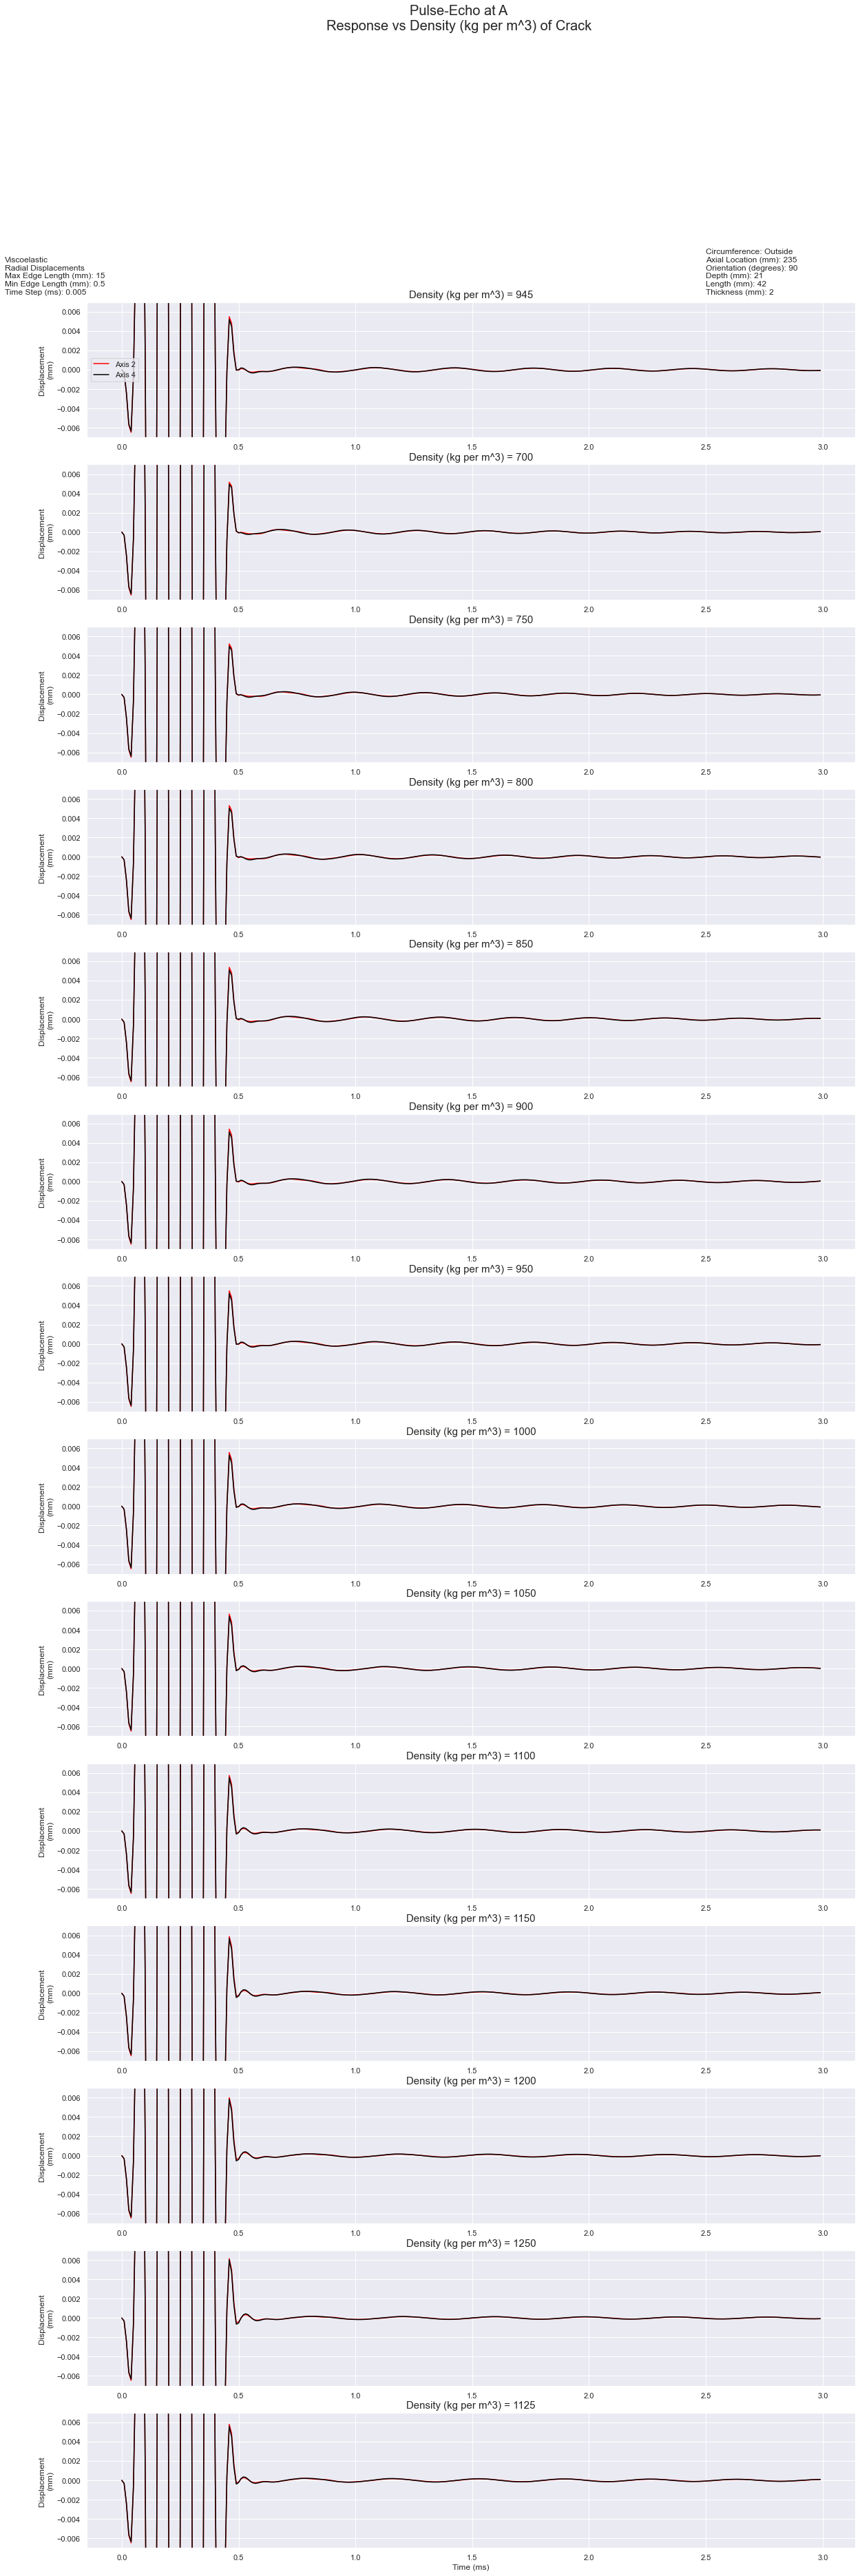

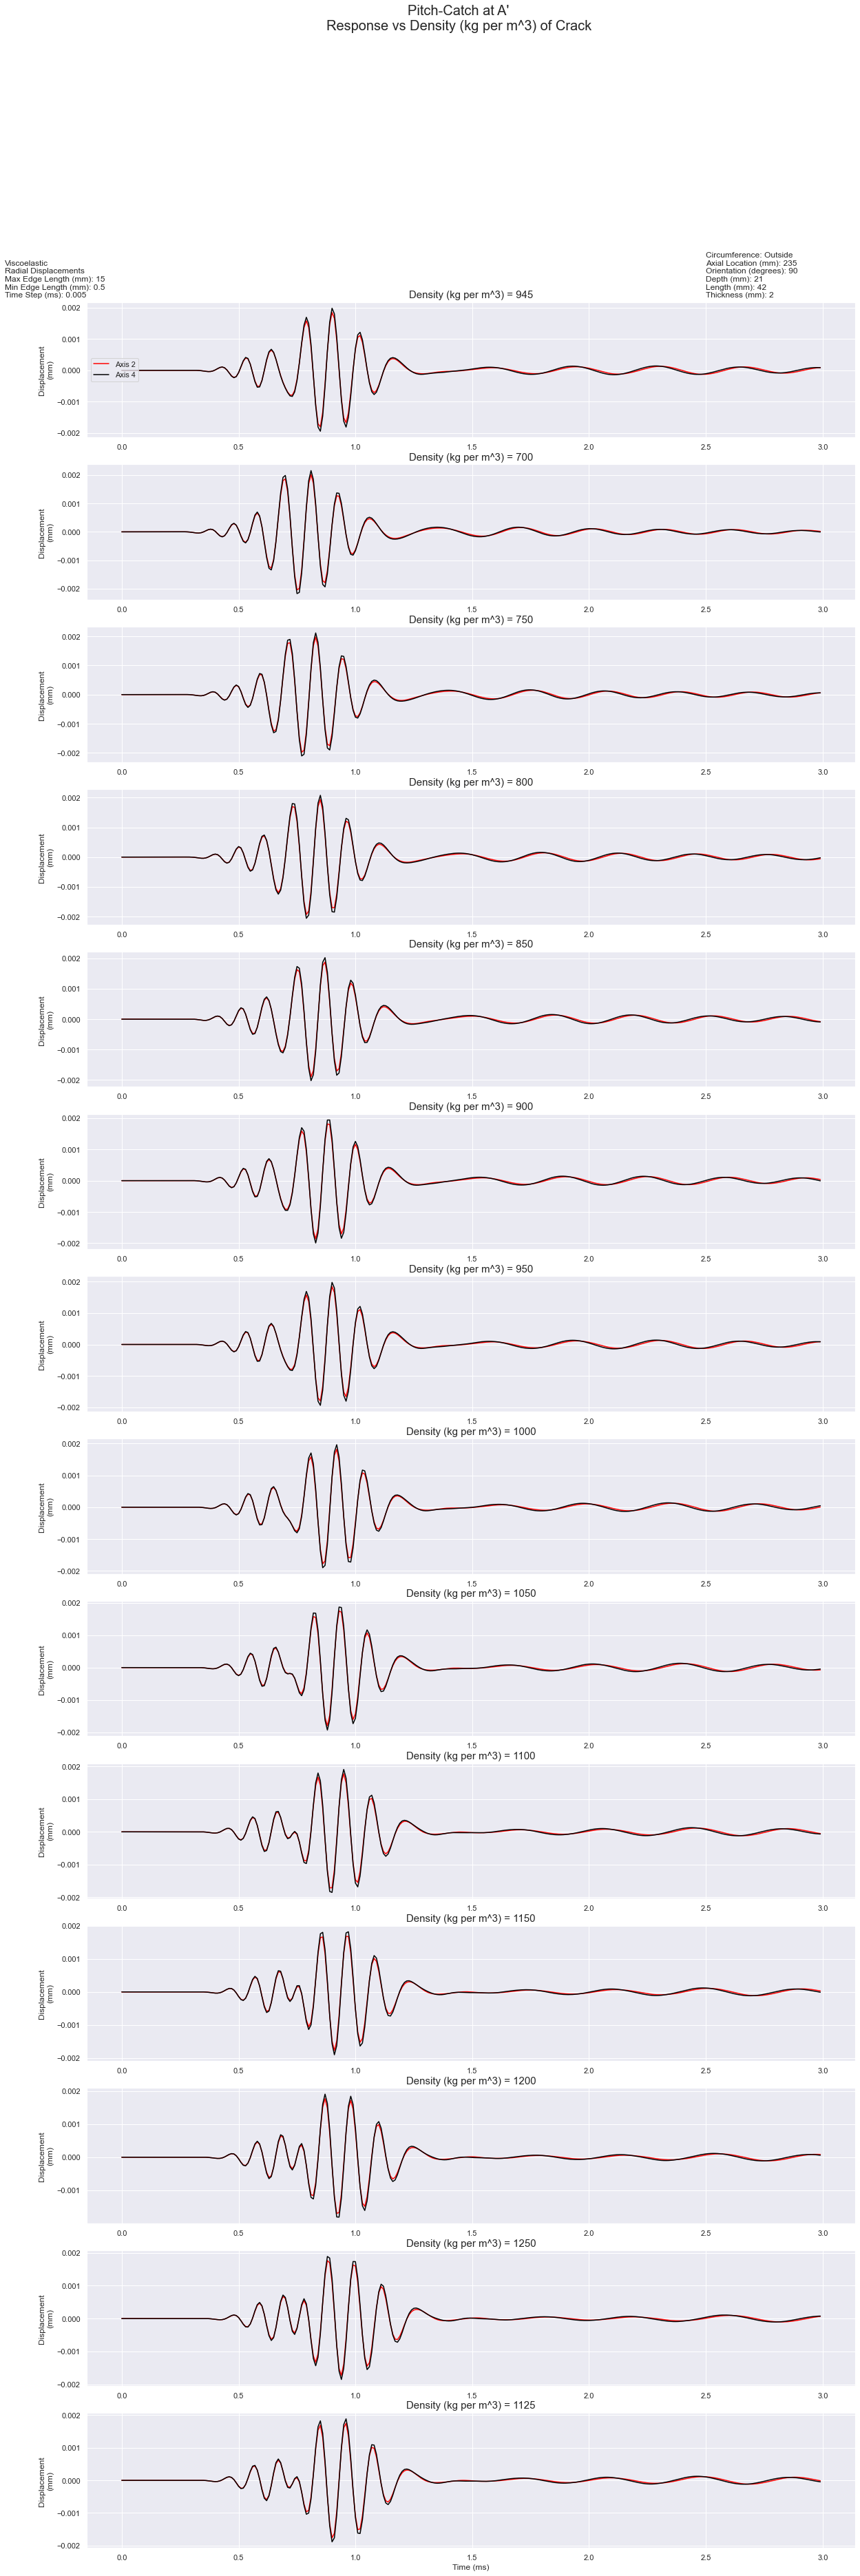

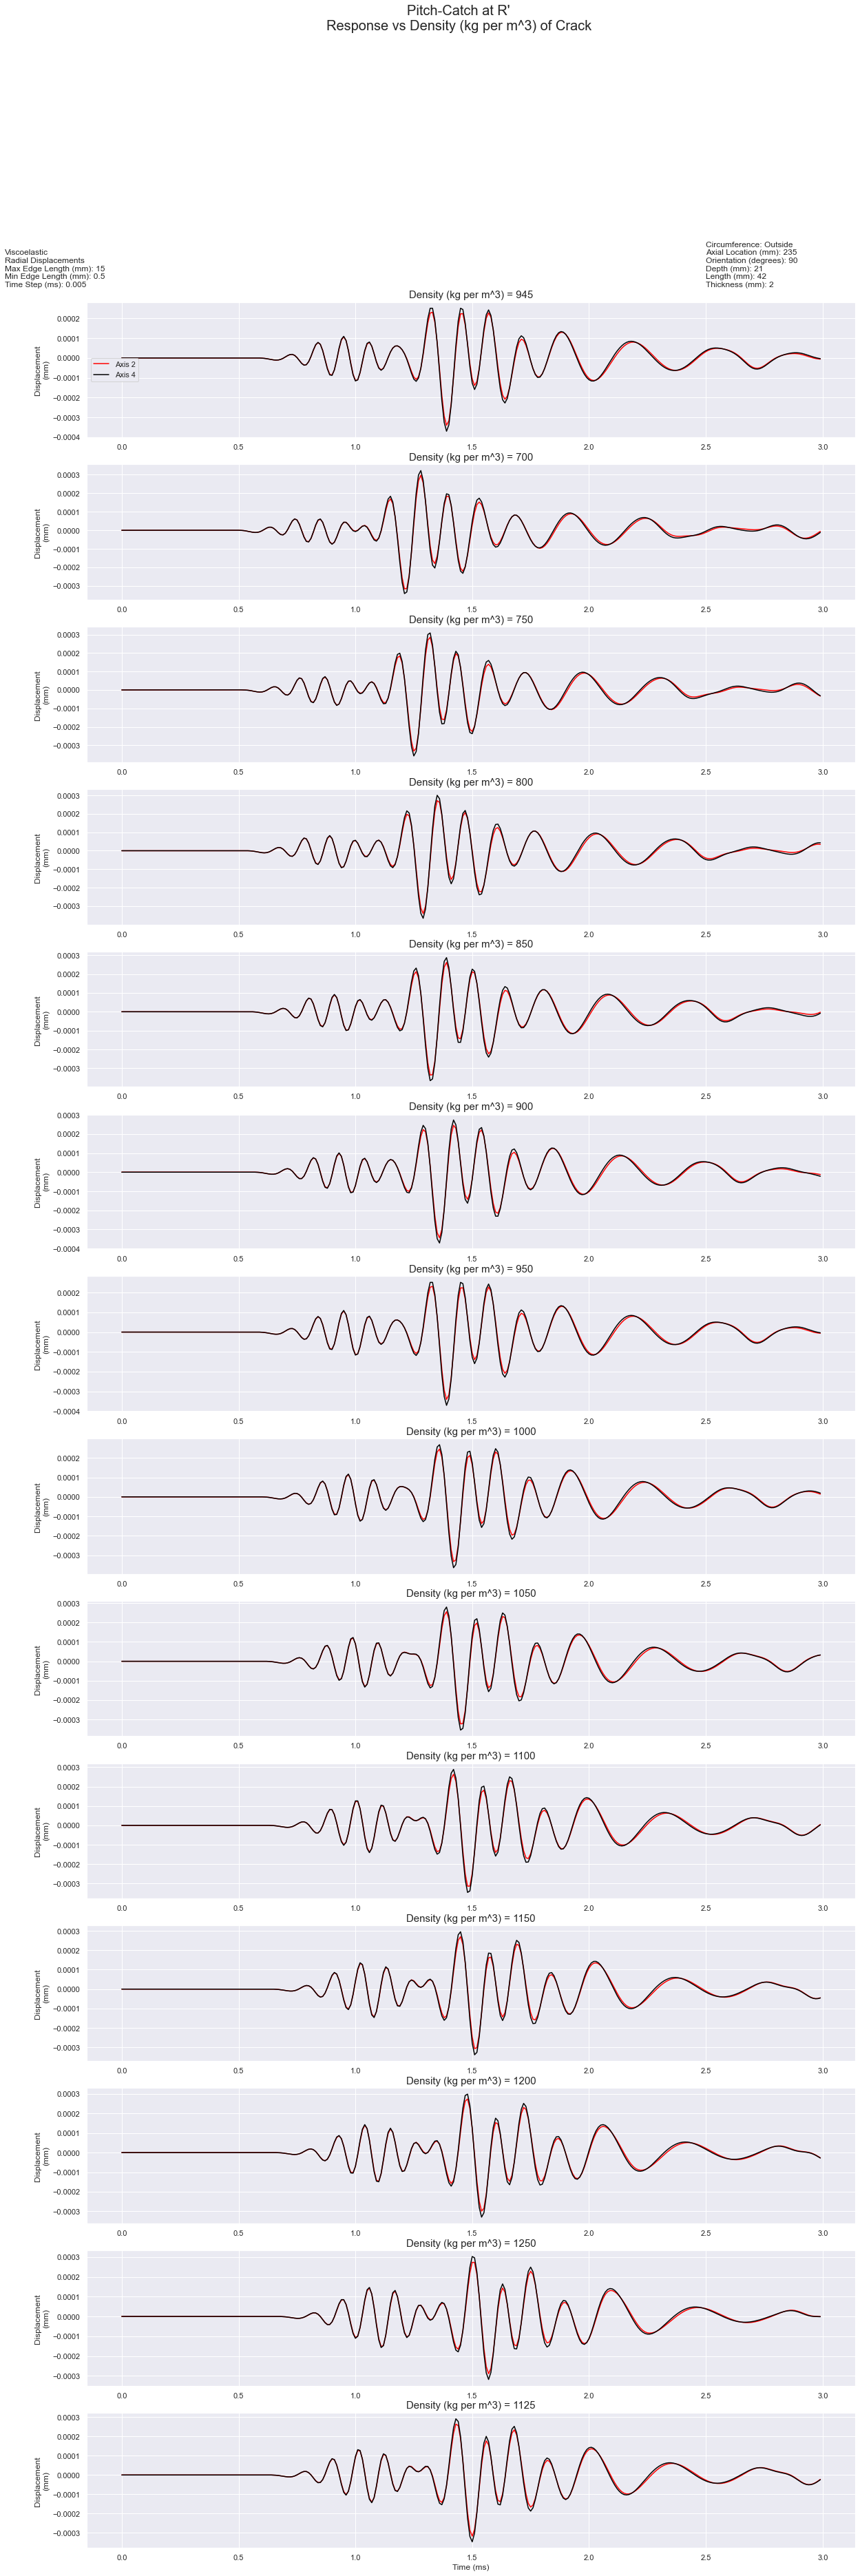

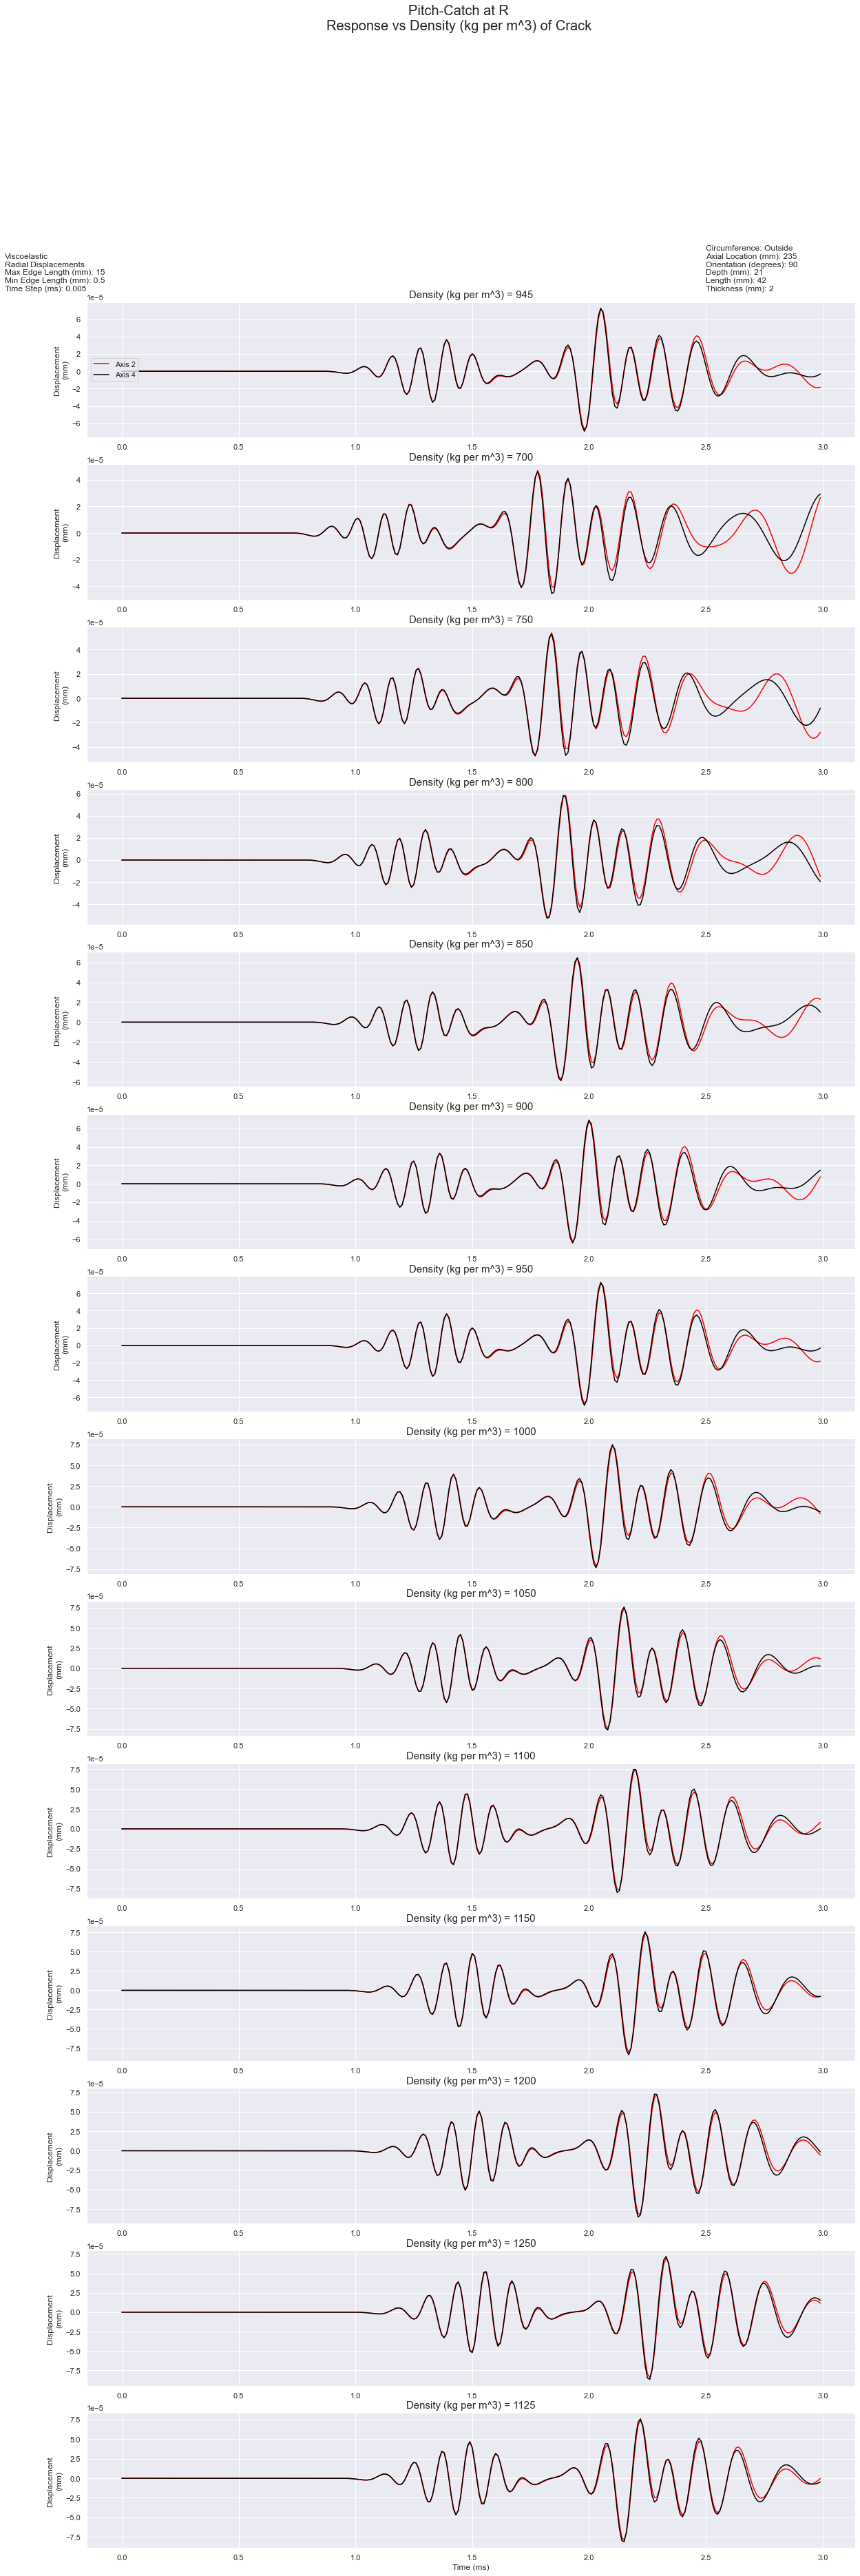

In [580]:
for Array in damage_by_arrays.keys():
    
    if Array == 'A':
        Configuration = 'Pulse-Echo'
    else:
        Configuration = 'Pitch-Catch'
    
    fig, ax = plt.subplots(no_ds, 1, figsize = (20,60))
    i = 0
    
    while i < no_ds:
        state = states[i]
        j = 0;
        subtitle = '';

        while j < no_axes:
            axis = axes[j];

            is_state = damage_by_arrays[Array][category,variable] == states[i];
            is_axis  = damage_by_arrays[Array]['Transducer','Axis'] == float(axes[j]);
            signal   = damage_by_arrays[Array][is_state & is_axis];

            signal_time = signal['Time Domain (ms)'];
            
            if Configuration == 'Pulse-Echo':
                ax[i].set_ylim([-0.007, 0.007])
            
            if np.nan in signal_time:
                continue

            # max_value = max(signal_time.to_numpy().transpose())
            max_value = signal_time.to_numpy().max()
            
            ax[i].plot(time.transpose(),signal_time.to_numpy().transpose() ,color = colors[j], label = 'Axis ' + str(Axes[j]));
            ax[i].set_ylabel('Displacement \n(mm)', fontsize = 12)

            j = j + 1;

        # if i == 0:
        #     subtitle = 'Undamaged'
        # elif state >= 20:
        #     subtitle = 'Through Thickness'
        # else:
        #     subtitle = variable + ': ' + str(states[i])
        subtitle = variable + ' = ' + str(state)
        ax[i].set_title(subtitle, fontsize = 15)
            
        i = i + 1;

    ax[-1].set_xlabel('Time (ms)', fontsize = 12)

    ax[0].legend(loc = 'center left', ncol = 1)
    
    if Configuration == 'Pulse-Echo':
        textyloc = 0.007;
    else:
        textyloc = max_value*1.1;

    ax[0].text(-0.5, textyloc, parameters, fontsize=12)
    ax[0].text(2.5, textyloc, crack_props, fontsize=12)

    fig.suptitle(Configuration + ' at '+ Array +'\nResponse vs ' + variable + ' of Crack',fontsize = 20)

    # fig.savefig(rray + ' ' + savename,dpi = 250)
    fig.savefig(Array + ' ' + savename, dpi = 250)
    # fig.savefig(os.path.join(directory, Array + ' ' + savename))

In [581]:
pickle.dump(damage_by_arrays,open('Damage by Arrays','ab'))

In [582]:
os.getcwd()

'G:\\My Drive\\USGW Research\\Programming\\Git Practice\\Ultrasonic-Guided-Waves-in-Polyethylene-Pipes\\Varying Density (kg per m^3)'

### Frequency Domain Plots

In [583]:
savename = Pipe_model + ' Amplitude Spectrum ' + Elasticity + ' ' + disps + ' ' + str(meshmin) + '-' + str(meshmax) + ' mm Mesh ' + str(timestep) + ' ms Timestep'
savename += '.png'
savename

'Comsol 6.0 Model Amplitude Spectrum Viscoelastic Radial Displacements 0.5-15 mm Mesh 0.005 ms Timestep.png'

In [584]:
states

[945, 700, 750, 800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 1125]

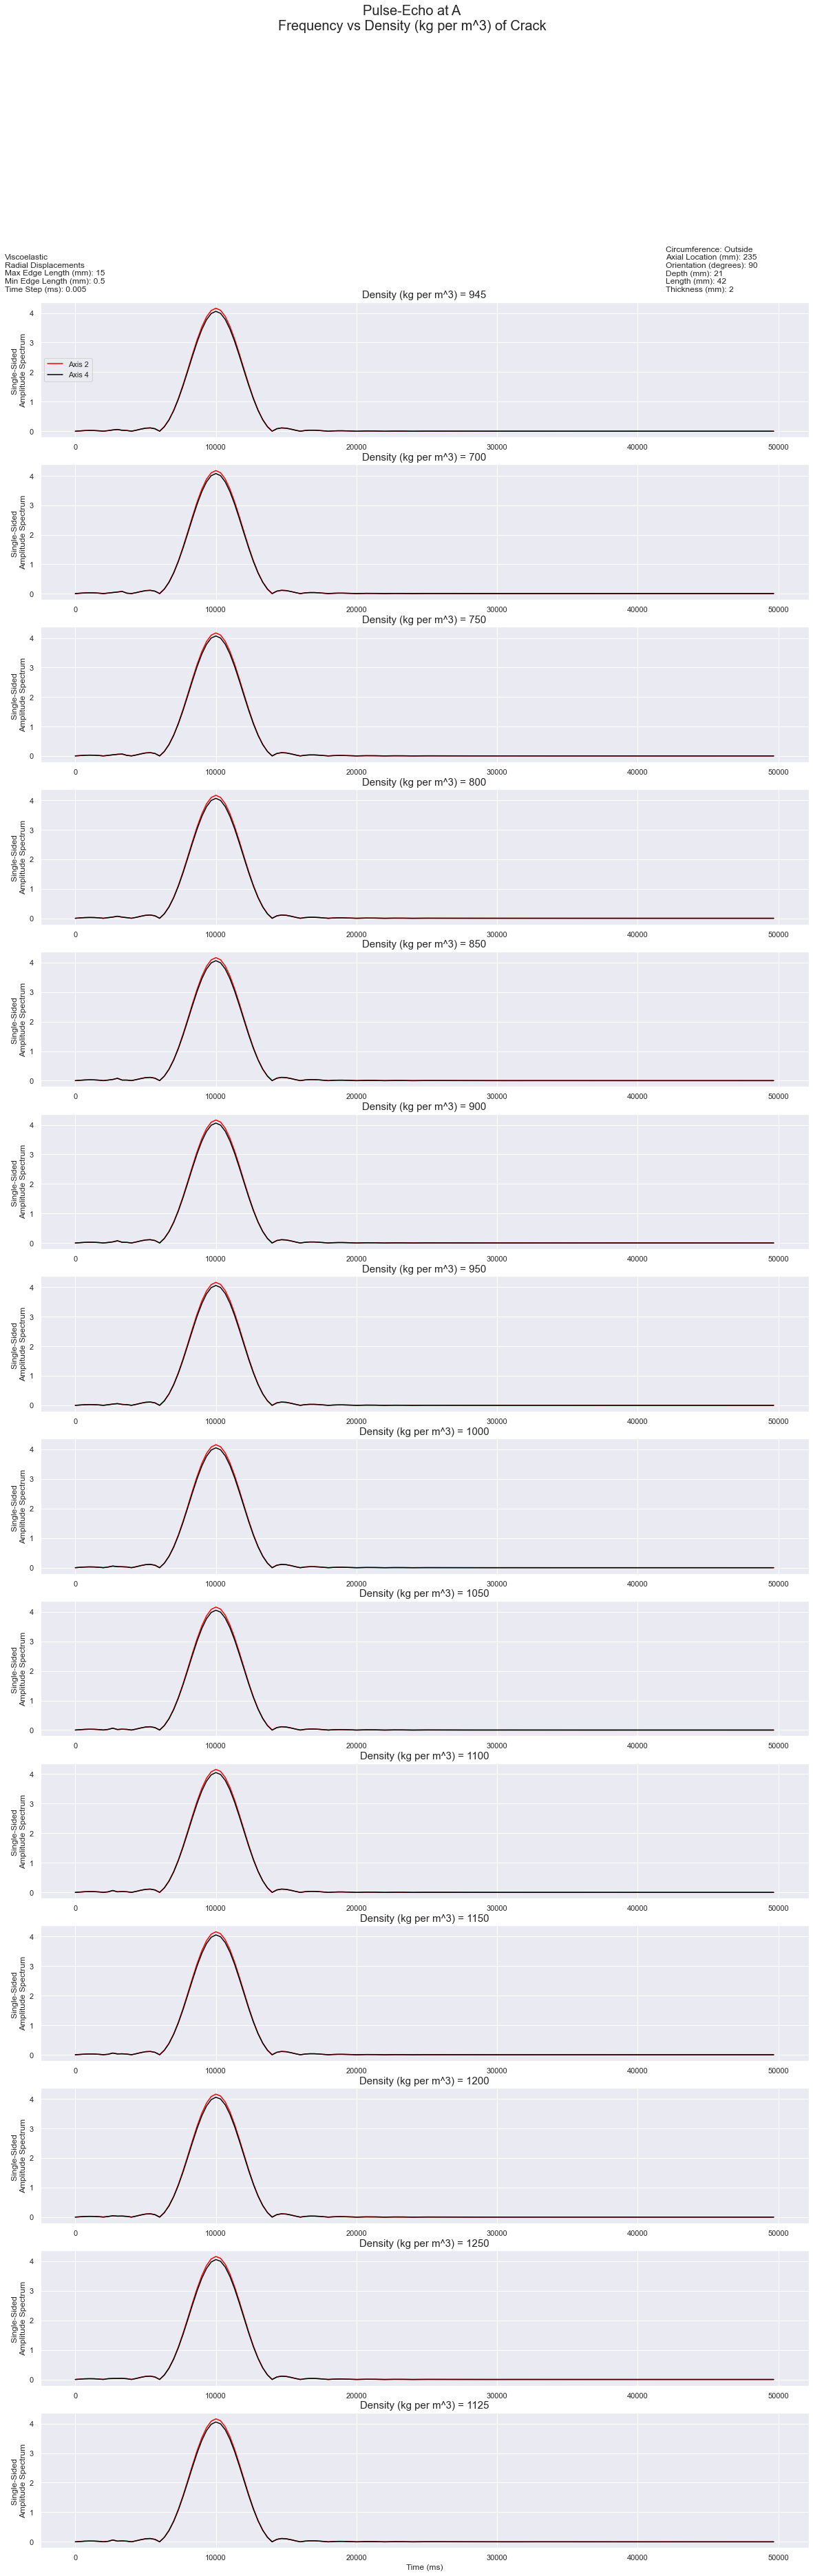

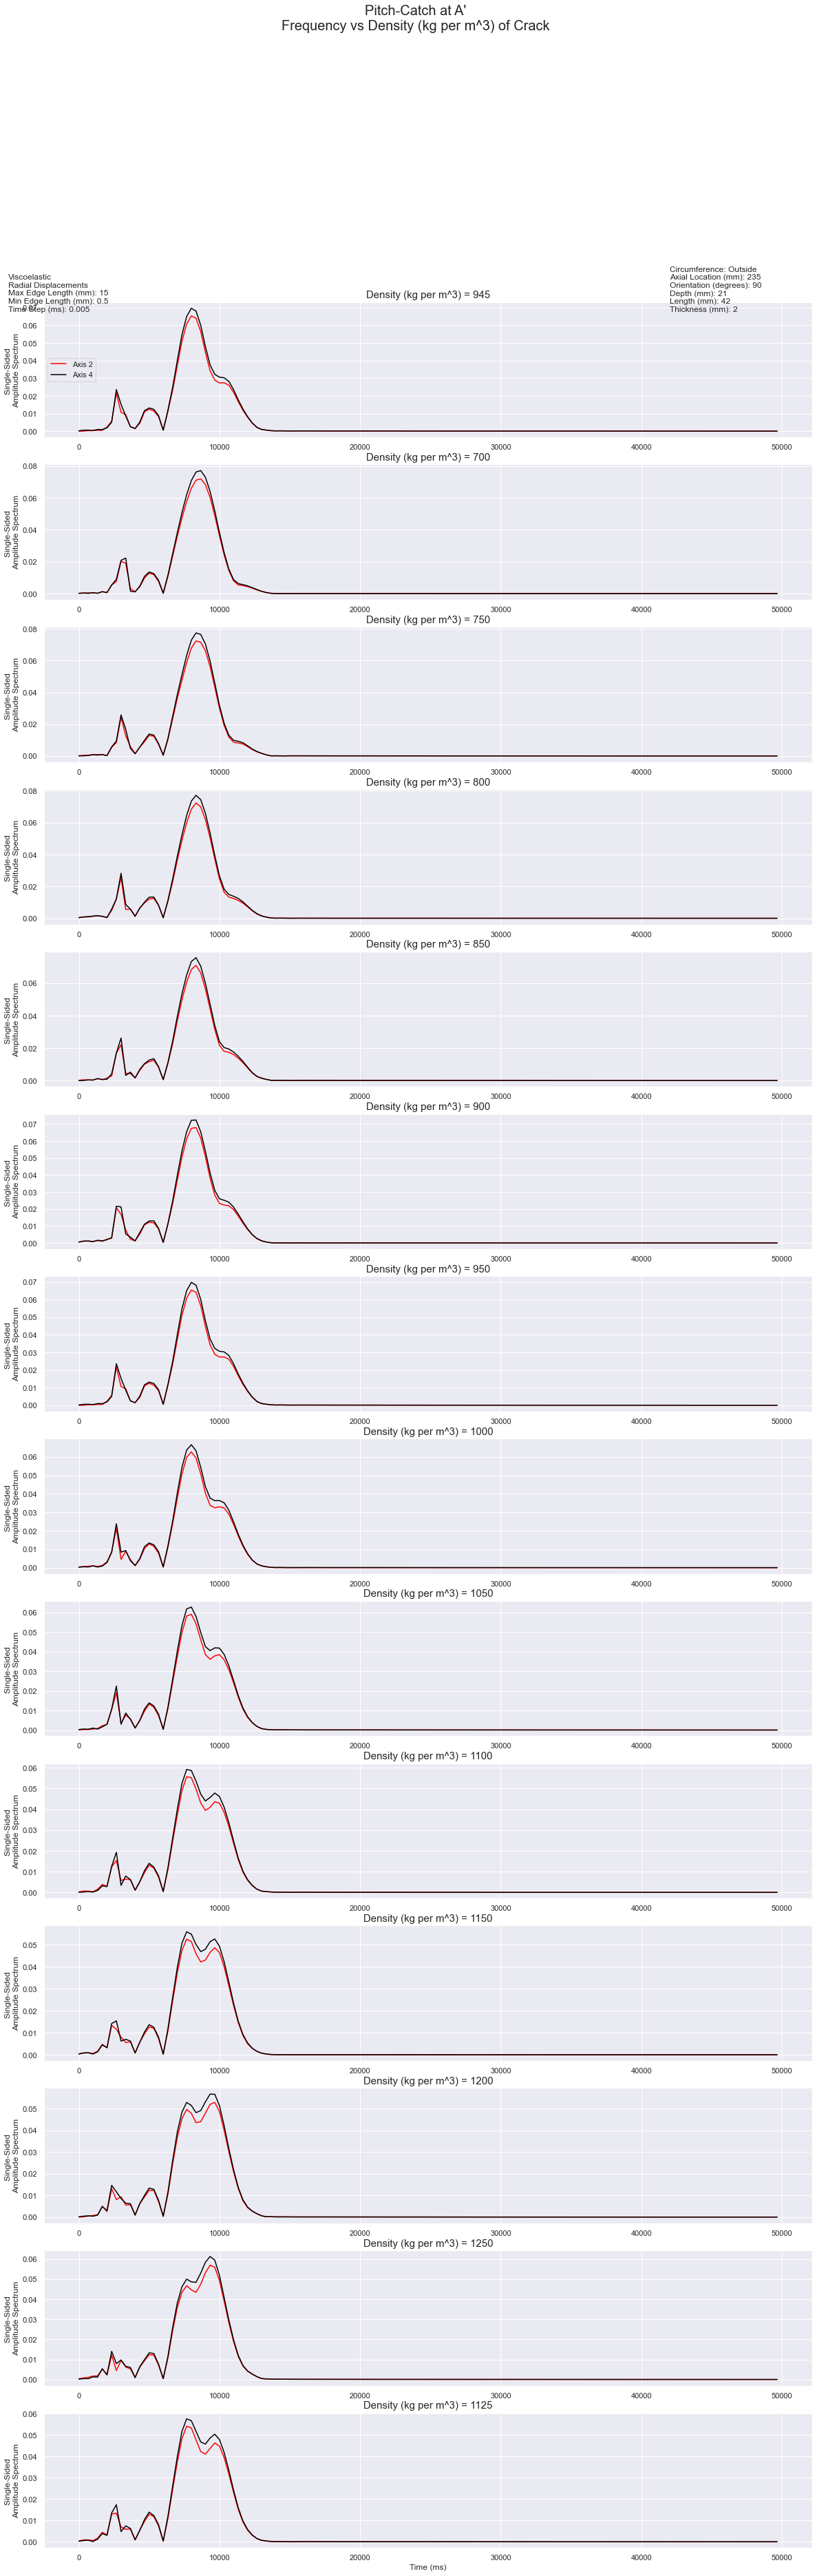

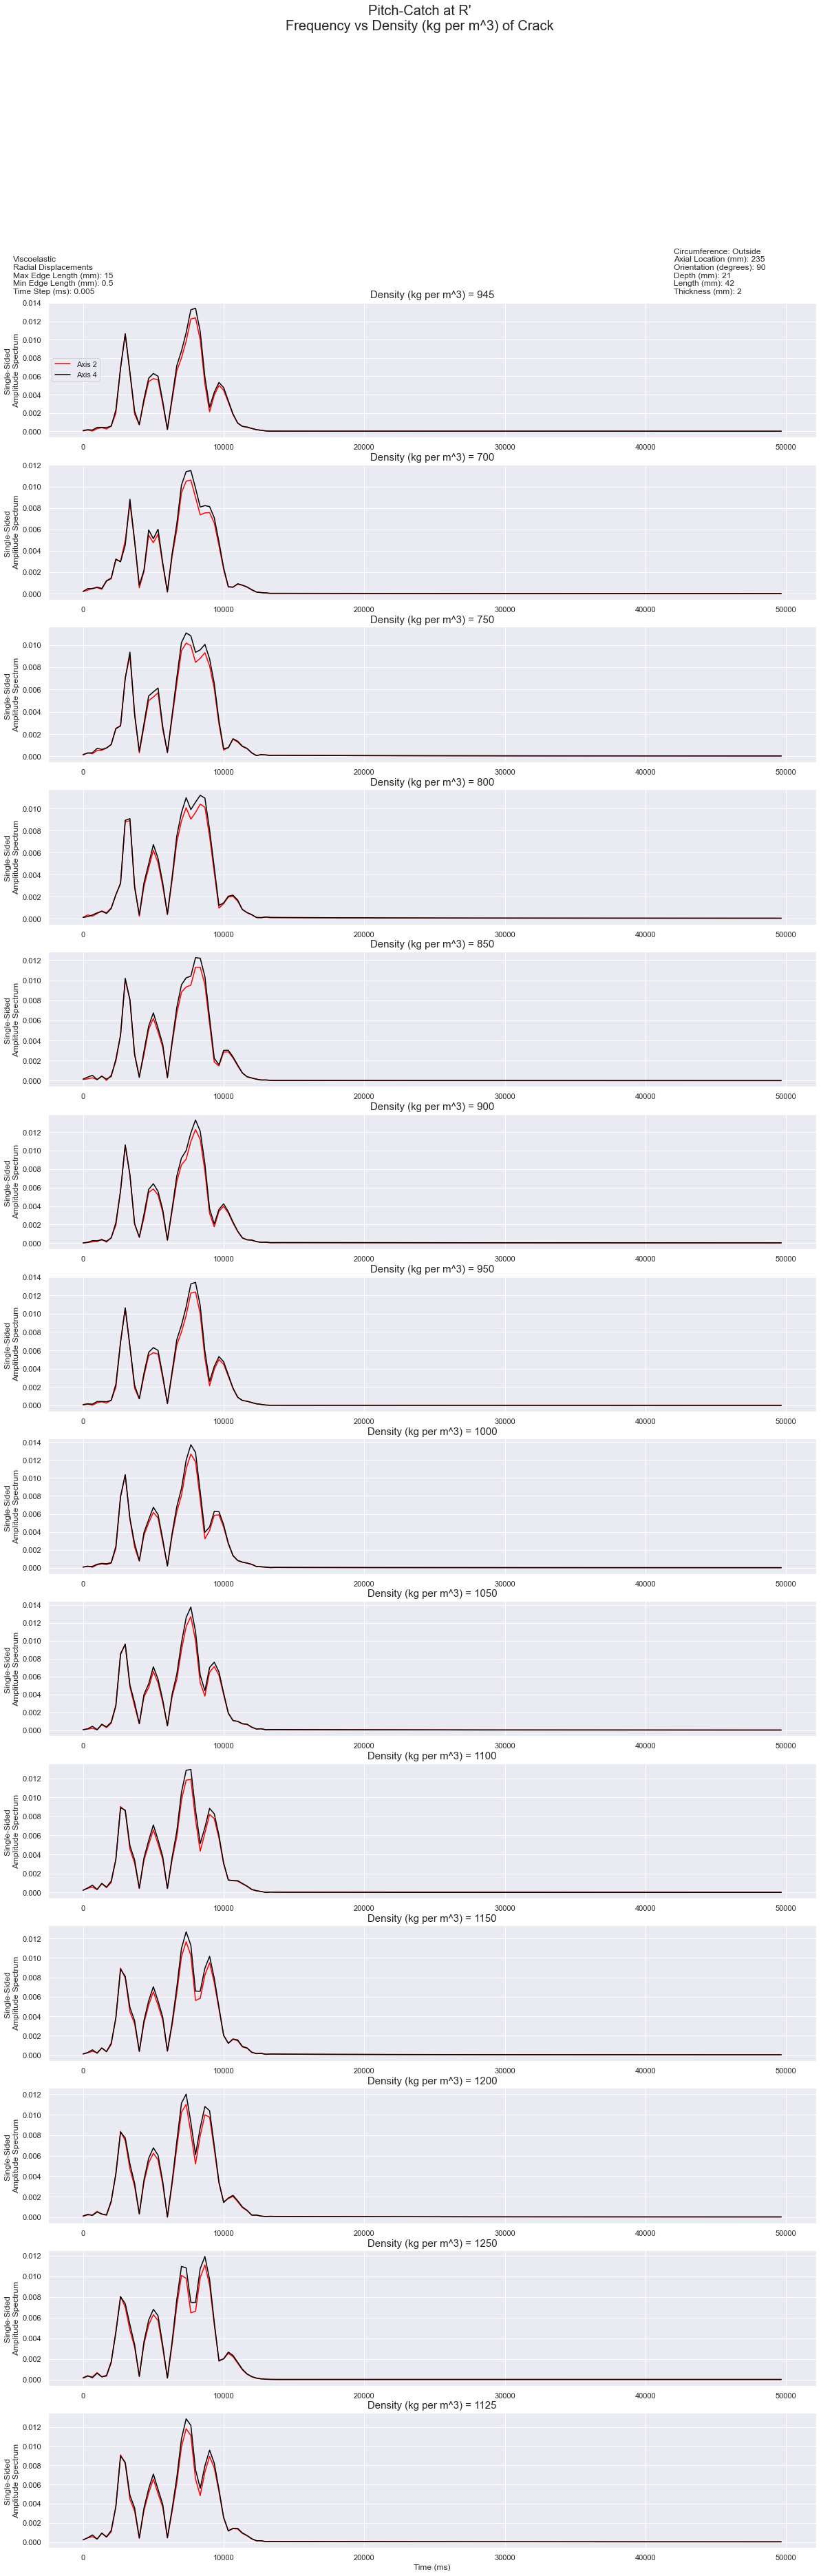

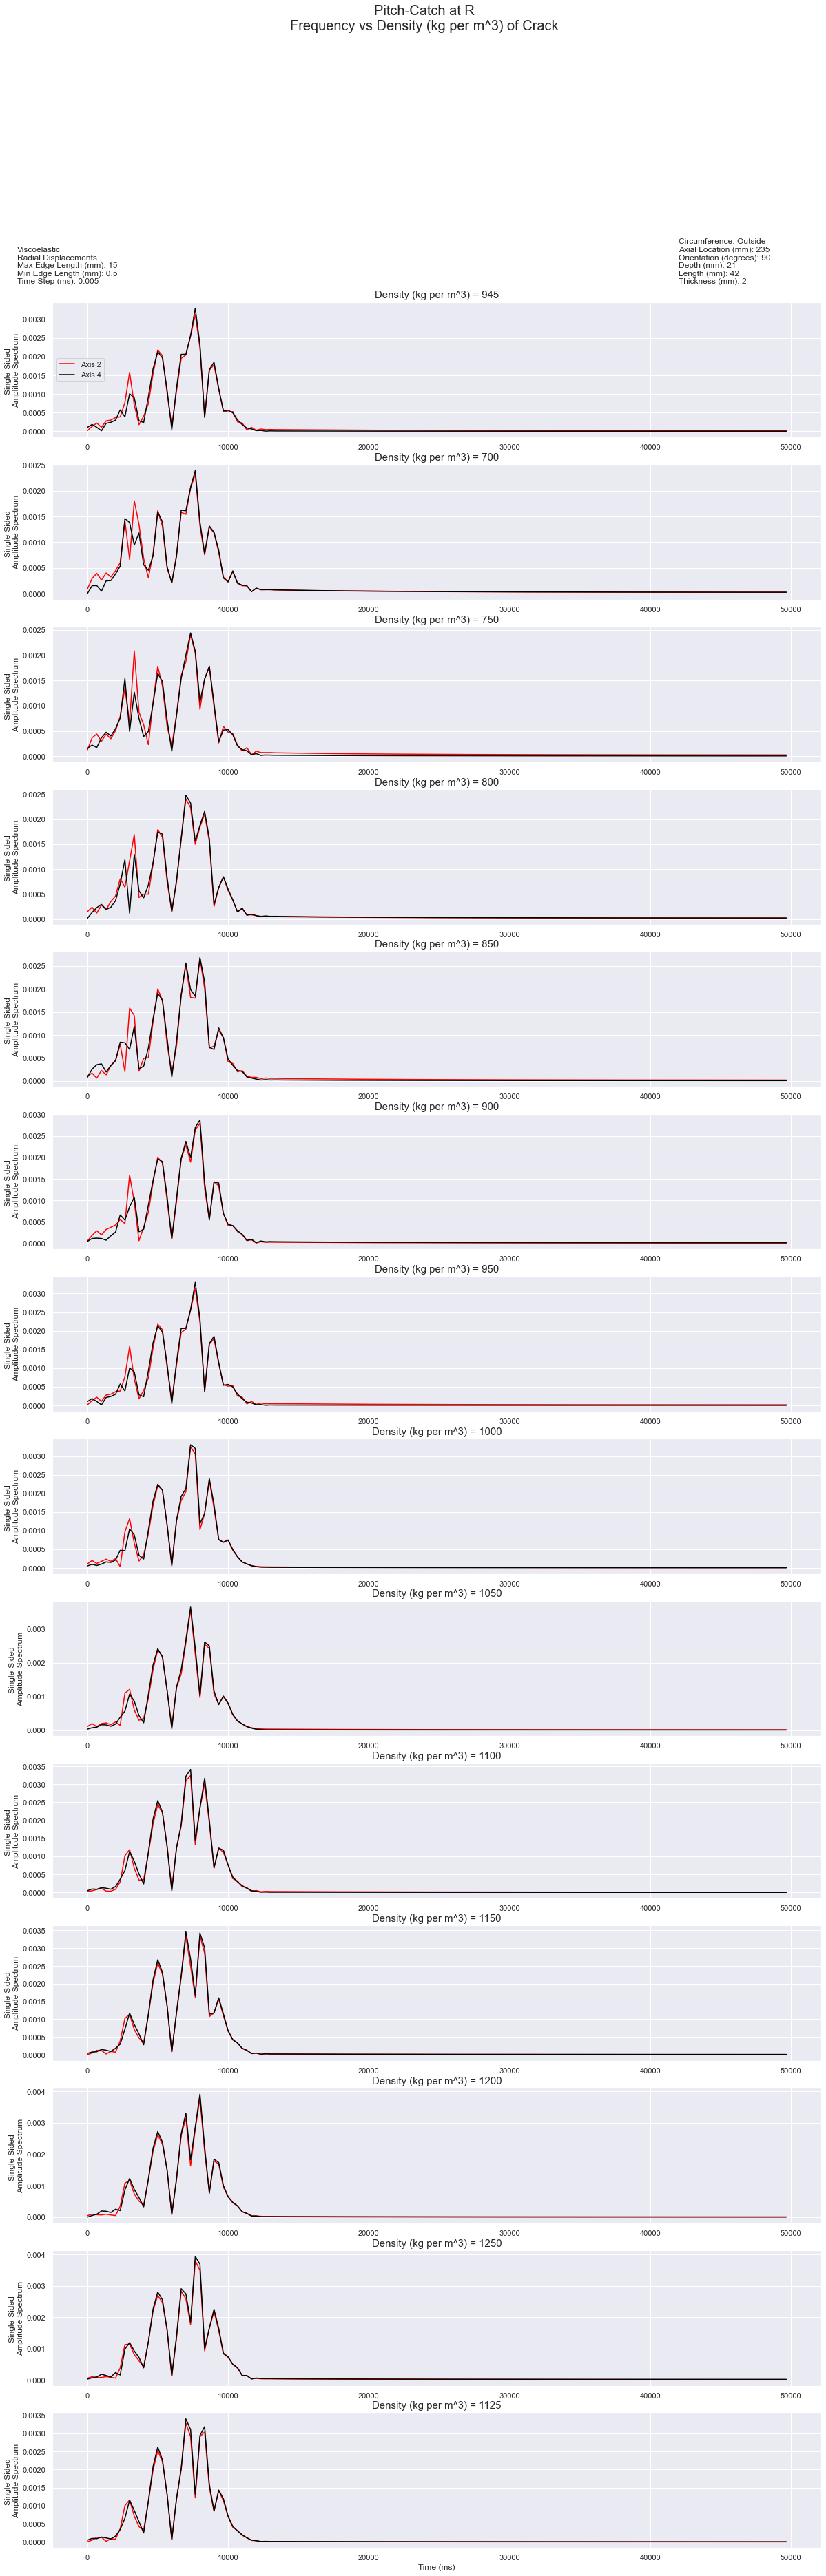

In [585]:
for Array in damage_by_arrays.keys():
    
    if Array == 'A':
        Configuration = 'Pulse-Echo'
    else:
        Configuration = 'Pitch-Catch'
    
    fig, ax = plt.subplots(no_ds, 1, figsize = (20,60))
    i = 0
    
    while i < no_ds:
        state = states[i]
        j = 0;
        subtitle = '';

        while j < no_axes:
            axis = axes[j];

            is_state = damage_by_arrays[Array][category,variable] == states[i];
            is_axis  = damage_by_arrays[Array]['Transducer','Axis'] == float(axes[j]);
            signal   = damage_by_arrays[Array][is_state & is_axis];

            signal_freq = signal['Frequency Domain (Hz)'];
            
            if np.nan in signal_freq:
                continue

            max_value = signal_freq.to_numpy().max()
            
            ax[i].plot(damage_by_arrays[Array]['Frequency Domain (Hz)'].columns,signal_freq.to_numpy().transpose() ,color = colors[j], label = 'Axis ' + str(Axes[j]));
            ax[i].set_ylabel('Single-Sided \nAmplitude Spectrum', fontsize = 12)

            j = j + 1;

        # if i == 0:
        #     subtitle = 'Undamaged'
        # elif state >= 20:
        #     subtitle = 'Through Thickness'
        # else:
        #     subtitle = variable + ': ' + str(states[i])
        subtitle = variable + ' = ' + str(state)
        ax[i].set_title(subtitle, fontsize = 15)
            
        i = i + 1;

    ax[-1].set_xlabel('Time (ms)', fontsize = 12)

    ax[0].legend(loc = 'center left', ncol = 1)

    textyloc = max_value*1.1;

    ax[0].text(-5000, textyloc, parameters, fontsize=12)
    ax[0].text(42000, textyloc, crack_props, fontsize=12)

    fig.suptitle(Configuration + ' at '+ Array +'\nFrequency vs ' + variable + ' of Crack',fontsize = 20)

    # fig.savefig(Array + ' ' + savename,dpi = 250)
    
    fig.savefig(Array + ' Frequency Domain',dpi = 250)

In [586]:
ax[-1].get_ylim()

(-0.0001687979572531602, 0.0035706243341482214)

### DWT Spectrogram

The discrete wavelet transform is an operation by which a mother wavelet (Daubacheis 1 in this case) is dilated and shifted across the domain of the signal in order to reconstruct it in a number of different frequencies. 

In [587]:
coeffs = pywt.wavedec(signal_time, 'db1', mode = 'sym', level = 5); # DWT
cA5, cD5, cD4, cD3, cD2, cD1 = coeffs

In [588]:
no_coeffs = 6;

In [589]:
crack_props = ''
for crack_geom_param in crack_geom_params:
    crack_props += crack_geom_param + ': ' + str(crack_geom[crack_geom_param]) + '\n'
    
crack_props

'Circumference: Outside\nAxial Location (mm): 235\nOrientation (degrees): 90\nDepth (mm): 21\nLength (mm): 42\nThickness (mm): 2\n'

In [590]:
parameters = Elasticity + '\n' + disps + '\n'
for intervals_param in intervals_params:
    parameters += intervals_param + ': ' + str(intervals[intervals_param]) + '\n'
    
parameters

'Viscoelastic\nRadial Displacements\nMax Edge Length (mm): 15\nMin Edge Length (mm): 0.5\nTime Step (ms): 0.005\n'

In [591]:
savename = Pipe_model + ' DWT ' + Elasticity + ' ' + disps + ' ' + str(meshmin) + '-' + str(meshmax) + ' mm Mesh ' + str(timestep) + ' ms Timestep'
savename += '.png'
savename

'Comsol 6.0 Model DWT Viscoelastic Radial Displacements 0.5-15 mm Mesh 0.005 ms Timestep.png'

KeyError: 1535

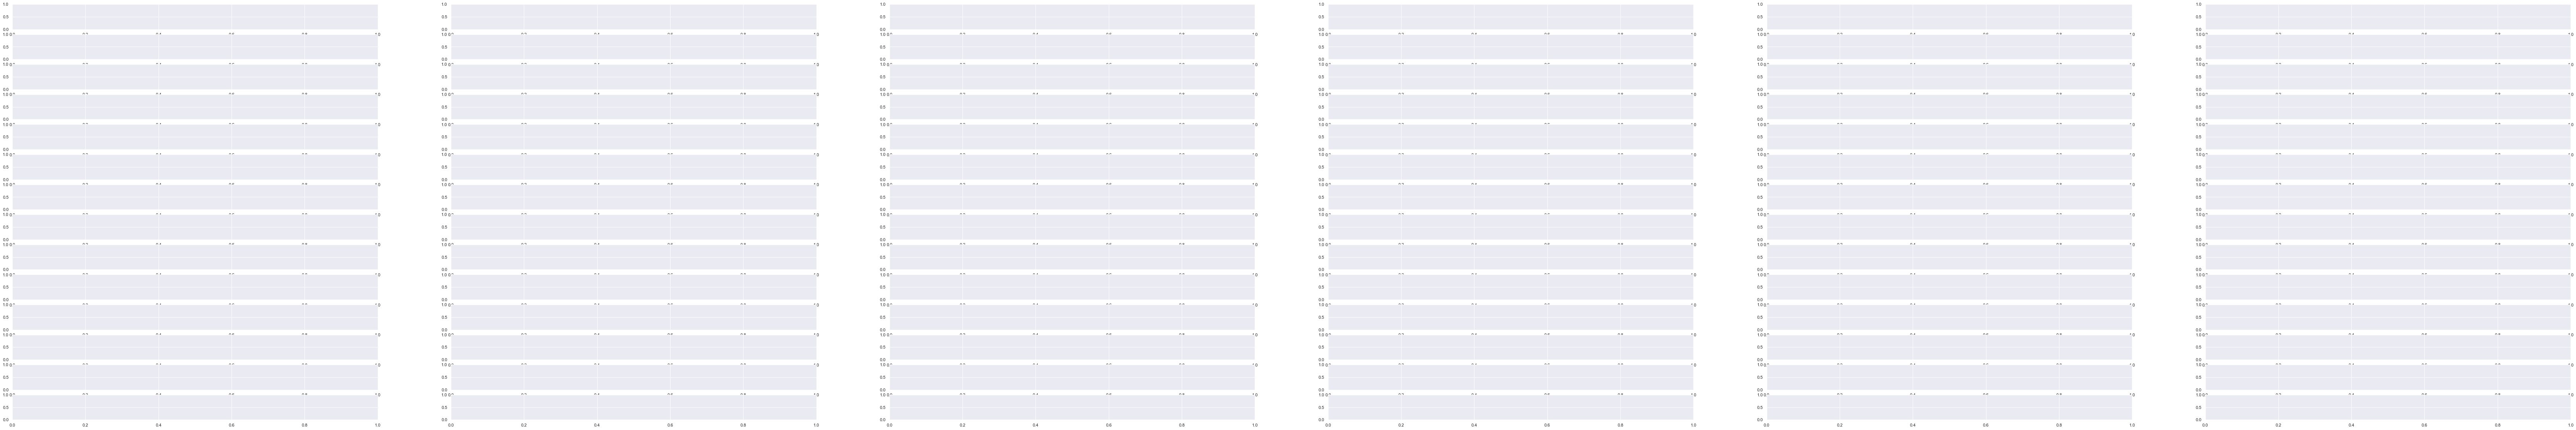

In [592]:
for Array in damage_by_arrays.keys():
    
    if Array == 'A':
        Configuration = 'Pulse-Echo'
    else:
        Configuration = 'Pitch-Catch'
    
    fig, ax = plt.subplots(no_ds, no_coeffs, figsize = (120,20))
    i = 0
    
    while i < no_ds:
        state = states[i]
        j = 0;
        subtitle = '';

        while j < no_axes:
            axis = axes[j];

            is_state = damage_by_arrays[Array]['Crack Properties',variable] == states[i];
            is_axis  = damage_by_arrays[Array]['Transducer','Axis'] == float(axes[j]);
            signal   = damage_by_arrays[Array][is_state & is_axis];

            signal_time = signal['Time Domain (ms)'];
            
            if np.nan in signal_time:
                continue

            max_value = signal_time.to_numpy().max()
            
            coeffs = pywt.wavedec(signal_time, 'db1', mode = 'sym', level = 5); # DWT
            cA5, cD5, cD4, cD3, cD2, cD1 = coeffs
            
            k = 0
            for coeff in coeffs:
                
                if Configuration == 'Pulse-Echo':
                    ax[i][k].set_ylim([-0.007, 0.007])
                
                samples = np.arange(0,len(coeff.transpose()))
                ax[i][k].plot(samples,coeff.transpose() ,color = colors[j], label = 'Axis ' + str(Axes[j]));
                ax[i][k].set_ylabel('Displacement \n(mm)', fontsize = 12)
                                
                if i == 0:
                    subtitle = 'Undamaged'
                elif state >= 20:
                    subtitle = 'Through Thickness'
                else:
                    subtitle = variable + ': ' + str(states[i])
                ax[i][k].set_title(subtitle, fontsize = 15)

                k = k + 1;

            j = j + 1;
            
        i = i + 1;


    ax[0][0].legend(loc = 'best', ncol = 1)
    
    if Configuration == 'Pulse-Echo':
        textyloc = 1.1*ax[0][0].get_ylim()[1];
    else:
        textyloc = max_value;

    ax[-1][0].set_xlabel('Samples \nApproximated Coefficient cA5', fontsize = 15)
    ax[-1][1].set_xlabel('Samples \nDetailed Coefficient cD5', fontsize = 15)
    ax[-1][2].set_xlabel('Samples \nDetailed Coefficient cD4', fontsize = 15)
    ax[-1][3].set_xlabel('Samples \nDetailed Coefficient cD3', fontsize = 15)
    ax[-1][4].set_xlabel('Samples \nDetailed Coefficient cD2', fontsize = 15)
    ax[-1][5].set_xlabel('Samples \nDetailed Coefficient cD1', fontsize = 15)
        
    ax[0][0].text(-0.05, textyloc, parameters, fontsize=17)
    ax[0][-1].text(110, textyloc, crack_props, fontsize=17)

    fig.suptitle(Configuration + ' at '+ Array +'\nDWT vs ' + variable + ' of Crack',fontsize = 40)

    # fig.savefig(Array + ' ' + savename,dpi = 250)

    fig.savefig(Array + ' DWT',dpi = 250)

## Add Noise

In order for the data to be categorized appropriately, there needs to be redundancy for each damaged state. Multiple trials will be created by adding random white noise according to a specified signal to noise ratio (SNR)

In [ ]:
num_samples = len(time.transpose())
signals     = damage_by_arrays
snr         = 10**(SNR_dB/10)   # Desired linear SNR

for Array in damage_by_arrays.keys():
    for seed in damage_by_arrays[Array].index:
        signal = damage_by_arrays[Array].loc[seed]
        for i in range(1,101):
            power = signal['Time Domain (ms)'].var()
            n     = power/snr
            noise = sp.sqrt(n)*sp.randn(num_samples)
            noisy_signal = signal;
            noisy_signal['Time Domain (ms)'] = np.add(signal['Time Domain (ms)'],noise).values
            # noisy_signal['Time Domain (ms)'] = np.array(noisy_signal['Time Domain (ms)']) + np.array(noise)
            noisy_signal['Pipe','Designation'] = 'Simulated Noisy Signal';
            signals[Array] = signals[Array].append(noisy_signal)

### Time-Averaged Signal Data

Populate a dictionary with signals at the arrays in which the noise is cancelled by averaging the signals over each damaged state. Do the same for a max signal value dictionary and a min signal value dictionary.

In [ ]:
averaged_signals = {}
max_signals      = {}
min_signals      = {}

for Array in signals.keys():
    is_noisy = signals[Array]['Pipe','Designation'] == 'Simulated Noisy Signal'
    
    averaged_signals[Array] = signals[Array][is_noisy].groupby([signals[Array][is_noisy]['Crack Properties',variable],signals[Array][is_noisy]['Transducer','Axis']]).mean()
    max_signals[Array]      = signals[Array][is_noisy].groupby([signals[Array][is_noisy]['Crack Properties',variable],signals[Array][is_noisy]['Transducer','Axis']]).max()
    min_signals[Array]      = signals[Array][is_noisy].groupby([signals[Array][is_noisy]['Crack Properties',variable],signals[Array][is_noisy]['Transducer','Axis']]).min()
    

In [ ]:
pickle.dump(signals,open('FE Noisy Signals','ab'))

### Frequency Domain over all Noisy Data and Time-Averaged Data

In [ ]:
for Array in signals.keys():
    P1_noisy = ssas(Fs, signals[Array]['Time Domain (ms)'])
    for freq in P1_noisy.columns:
        signals[Array][freq] = P1_noisy[freq].values

In [ ]:
for Array in averaged_signals.keys():
    P1_averaged = ssas(Fs, averaged_signals[Array]['Time Domain (ms)'])
    for freq in P1_averaged.columns:
        averaged_signals[Array][freq] = P1_averaged[freq].values

### Plot all New Data upon Introduction of Noise

In [ ]:
savename = Pipe_model + ' Noisy Response ' + Elasticity + ' ' + disps + ' ' + str(meshmin) + '-' + str(meshmax) + ' mm Mesh ' + str(timestep) + ' ms Timestep'
savename += '.png'
savename

In [ ]:
for Array in signals.keys():
    
    if Array == 'A':
        Configuration = 'Pulse-Echo'
    else:
        Configuration = 'Pitch-Catch'
    
    fig, ax = plt.subplots(no_ds, 2, figsize = (15,20))
    i = 0
    
    while i < no_ds:
        state = states[i]
        j = 0;
        subtitle = '';
        
        while j < no_axes:
            axis = axes[j];

            is_state = averaged_signals[Array]['Crack Properties',variable] == states[i];
            is_axis  = averaged_signals[Array]['Transducer','Axis'] == float(axes[j]);
            signal   = averaged_signals[Array][is_state & is_axis];

            signal_time = signal['Time Domain (ms)'];
            
            if Configuration == 'Pulse-Echo':
                ax[i][0].set_ylim([-0.01, 0.01])
            
            if np.nan in signal_time:
                continue

            max_value = signal_time.to_numpy().max()
            
            ax[i][0].plot(time.transpose(),signal_time.to_numpy().transpose() ,color = colors[j], label = 'Axis ' + str(Axes[j]));
            ax[i][0].set_ylabel('Displacement \n(mm)', fontsize = 12)

            j = j + 1;
            
        j = 0

        while j < no_axes:
            axis = axes[j];

            is_state = signals[Array]['Crack Properties',variable] == states[i];
            is_axis  = signals[Array]['Transducer','Axis'] == float(axes[j]);
            signal   = signals[Array][is_state & is_axis];

            signal_time = signal['Time Domain (ms)'];
            
            if Configuration == 'Pulse-Echo':
                ax[i][1].set_ylim([-0.01, 0.01])
            
            if np.nan in signal_time:
                continue

            # max_value = max(signal_time.to_numpy().transpose())
            max_value = signal_time.to_numpy().max()
            
            ax[i][1].plot(time.transpose(),signal_time.to_numpy().transpose() ,color = colors[j], label = 'Axis ' + str(Axes[j]));
            ax[i][1].set_ylabel('Displacement \n(mm)', fontsize = 12)

            j = j + 1;

        if i == 0:
            subtitle = 'Undamaged'
        elif state >= 20:
            subtitle = 'Through Thickness'
        else:
            subtitle = variable + ': ' + str(states[i])
        ax[i][0].set_title(subtitle, fontsize = 15)
        ax[i][1].set_title(subtitle, fontsize = 15)
            
        i = i + 1;

    ax[-1][0].set_xlabel('Time (ms)', fontsize = 12)
    ax[-1][1].set_xlabel('Time (ms)', fontsize = 12)

    # ax[0].legend(loc = 'center left', ncol = 1)
    
    if Configuration == 'Pulse-Echo':
        textyloc = 0.015;
    else:
        textyloc = max_value*1.7;

    ax[0][0].text(-0.5, textyloc, parameters, fontsize=12)
    ax[0][-1].text(2.0, textyloc, crack_props, fontsize=12)
    
    ax[0][0].text(0.8, 1*textyloc, 'Time-Averaged Signal', fontsize = 17)
    ax[0][1].text(1.1, 1*textyloc, 'Noisy Signals', fontsize = 17)

    fig.suptitle(Configuration + ' at '+ Array +'\nResponse vs ' + variable + ' of Crack',fontsize = 20)

    # fig.savefig(Array + ' ' + savename,dpi = 250)

    fig.savefig(Array + ' Noisy Time Domain.png',dpi = 250)

In [ ]:
savename = Pipe_model + ' Noisy Amplitude Spectrum ' + Elasticity + ' ' + disps + ' ' + str(meshmin) + '-' + str(meshmax) + ' mm Mesh ' + str(timestep) + ' ms Timestep'
savename += '.png'
savename

In [ ]:
for Array in signals.keys():
    
    if Array == 'A':
        Configuration = 'Pulse-Echo'
    else:
        Configuration = 'Pitch-Catch'
    
    fig, ax = plt.subplots(no_ds, 2, figsize = (15,20))
    i = 0
    
    while i < no_ds:
        state = states[i]
        j = 0;
        subtitle = '';
        
        while j < no_axes:
            axis = axes[j];

            is_state = signals[Array]['Crack Properties',variable] == states[i];
            is_axis  = signals[Array]['Transducer','Axis'] == float(axes[j]);
            signal   = signals[Array][is_state & is_axis];

            signal_freq = signal['Frequency Domain (Hz)'];
            
            if np.nan in signal_freq:
                continue

            max_value = signal_freq.to_numpy().max()
            
            ax[i][0].plot(signal_freq.columns,signal_freq.to_numpy().transpose() ,color = colors[j], label = 'Axis ' + str(Axes[j]));
            ax[i][0].set_ylabel('Single-Sided Amplitude Spectrum', fontsize = 12)

            j = j + 1;
            
        j = 0

        while j < no_axes:
            axis = axes[j];

            is_state = averaged_signals[Array]['Crack Properties',variable] == states[i];
            is_axis  = averaged_signals[Array]['Transducer','Axis'] == float(axes[j]);
            signal   = averaged_signals[Array][is_state & is_axis];

            signal_freq = signal['Frequency Domain (Hz)'];
            
            if np.nan in signal_freq:
                continue

            max_value = signal_freq.to_numpy().max()
            
            ax[i][1].plot(signal_freq.columns,signal_freq.to_numpy().transpose() ,color = colors[j], label = 'Axis ' + str(Axes[j]));
            ax[i][1].set_ylabel('Single-Sided Amplitude Spectrum', fontsize = 12)

            j = j + 1;

        if i == 0:
            subtitle = 'Undamaged'
        elif state >= 20:
            subtitle = 'Through Thickness'
        else:
            subtitle = variable + ': ' + str(states[i])
        ax[i][0].set_title(subtitle, fontsize = 15)
        ax[i][1].set_title(subtitle, fontsize = 15)
            
        i = i + 1;

    ax[-1][0].set_xlabel('Time (ms)', fontsize = 12)
    ax[-1][1].set_xlabel('Time (ms)', fontsize = 12)
    
    textyloc = max_value*1.1;

    ax[0][0].text(0, textyloc, parameters, fontsize=12)
    ax[0][-1].text(35000, textyloc, crack_props, fontsize=12)
    
    ax[-1][0].text(12000, -1*textyloc, 'Time-Averaged Signal', fontsize = 17)
    ax[-1][1].text(17000, -1*textyloc, 'Noisy Signals', fontsize = 17)

    fig.suptitle(Configuration + ' at '+ Array +'\nFrequency Domain vs ' + variable + ' of Crack',fontsize = 20)

    # fig.savefig(Array + ' ' + savename,dpi = 250)

    fig.savefig(Array + ' Noisy Frequency Domain.png',dpi = 250)

In [ ]:
savename = Pipe_model + ' Noisy Response ' + Elasticity + ' ' + disps + ' ' + str(meshmin) + '-' + str(meshmax) + ' mm Mesh ' + str(timestep) + ' ms Timestep'
savename += '.png'
savename

In [ ]:
for Array in averaged_signals.keys():
    
    if Array == 'A':
        Configuration = 'Pulse-Echo'
    else:
        Configuration = 'Pitch-Catch'
    
    fig, ax = plt.subplots(no_ds, no_coeffs, figsize = (120,20))
    i = 0
    
    while i < no_ds:
        state = states[i]
        j = 0;
        subtitle = '';

        while j < no_axes:
            axis = axes[j];

            is_state = averaged_signals[Array]['Crack Properties',variable] == states[i];
            is_axis  = averaged_signals[Array]['Transducer','Axis'] == float(axes[j]);
            signal   = averaged_signals[Array][is_state & is_axis];

            signal_time = signal['Time Domain (ms)'];
            
            if np.nan in signal_time:
                continue

            max_value = signal_time.to_numpy().max()
            
            coeffs = pywt.wavedec(signal_time, 'db1', mode = 'sym', level = 5); # DWT
            cA5, cD5, cD4, cD3, cD2, cD1 = coeffs
            
            k = 0
            for coeff in coeffs:
                
                if Configuration == 'Pulse-Echo':
                    ax[i][k].set_ylim([-0.007, 0.007])
                
                samples = np.arange(0,len(coeff.transpose()))
                ax[i][k].plot(samples,coeff.transpose() ,color = colors[j], label = 'Axis ' + str(Axes[j]));
                ax[i][k].set_ylabel('Displacement \n(mm)', fontsize = 12)
                                
                if i == 0:
                    subtitle = 'Undamaged'
                elif state >= 20:
                    subtitle = 'Through Thickness'
                else:
                    subtitle = variable + ': ' + str(states[i])
                ax[i][k].set_title(subtitle, fontsize = 15)

                k = k + 1;

            j = j + 1;
            
        i = i + 1;


    ax[0][0].legend(loc = 'best', ncol = 1)
    
    if Configuration == 'Pulse-Echo':
        textyloc = 1.1*ax[0][0].get_ylim()[1];
    else:
        textyloc = max_value;

    ax[-1][0].set_xlabel('Samples \nApproximated Coefficient cA5', fontsize = 15)
    ax[-1][1].set_xlabel('Samples \nDetailed Coefficient cD5', fontsize = 15)
    ax[-1][2].set_xlabel('Samples \nDetailed Coefficient cD4', fontsize = 15)
    ax[-1][3].set_xlabel('Samples \nDetailed Coefficient cD3', fontsize = 15)
    ax[-1][4].set_xlabel('Samples \nDetailed Coefficient cD2', fontsize = 15)
    ax[-1][5].set_xlabel('Samples \nDetailed Coefficient cD1', fontsize = 15)
        
    ax[0][0].text(-0.05, textyloc, parameters, fontsize=17)
    ax[0][-1].text(200, textyloc, crack_props, fontsize=17)

    fig.suptitle(Configuration + ' at '+ Array +'\nDWT vs ' + variable + ' of Crack',fontsize = 40)

    # fig.savefig(Array + ' ' + savename,dpi = 250)

    fig.savefig(Array + ' Noisy DWT',dpi = 250)

## Principal Component Analysis

Objective: Classify the noisy damage data via the amplitude of the frequency. 

Begin by zeroing in on only the frequencies which best describe teh signal. For our purposes, this will be the frequencies between 7,000 Hz and 13,000 Hz.

In [ ]:
imp_freqs = []
for freq in list(P1['Frequency Domain (Hz)'].columns):
    if (freq >= 7000):
        if (freq <= 12000):
            imp_freqs.append(freq)

Define the color markers for each damaged state

In [ ]:
colors_index = [0] * 20 
colors_index[0:len(states)] = states
colors = {colors_index[0]:'black', 
          colors_index[1]:'blue', 
          colors_index[2]:'green', 
          colors_index[3]:'purple', 
          colors_index[4]:'red'}
          # colors_index[5]:'magenta', 
          # colors_index[6]:'cyan', 
          # colors_index[7]:'black',
          # colors_index[8]:'pink',
          # colors_index[9]:'orange',
          # colors_index[10]:'olive',
          # colors_index[11]:'gray',
          # colors_index[12]:'maroon',
          # colors_index[13]:'darkgreen'}

colors

Plot all frequency domains on one graph per transducer array. Color-code them by damaged state. We're examining Axis 2, the axis with the crack.

Run a preliminary PCA analysis on the frequency domains to transform the data to a 2-PC space. Obtain the amount of variance from the original dataset explained by the principal components.

Finally, plot the transducer frequency response on the transformed plane. Because the variance is explained concisely with just two principal components, it should be much easier to cluster the damaged states on the transformed plane. 

In [ ]:
savename1 = Pipe_model + ' Damaged State as a Function of Frequency Variables '
savename1 += '.png'
savename1

savename2 = Pipe_model + ' Preliminary PCA '
savename2 += '.png'
savename2

savename3 = Pipe_model + ' Damaged State as a Function of Principal Components '
savename3 += '.png'
savename3

In [ ]:
all_pcs = {}
pc_data = {}

interest_freq_domains = {}

for Array in signals.keys():
    
    if Array == 'A':
        Configuration = 'Pulse-Echo'
    else:
        Configuration = 'Pitch-Catch'

    is_axis        = signals[Array]['Transducer','Axis'] == 2;
    interest_freqs = signals[Array][is_axis]['Frequency Domain (Hz)'][imp_freqs]
    interest_freqs[variable] = signals[Array][is_axis]['Crack Properties', variable]

    states = interest_freqs[variable].unique()
    
    interest_freq_domains[Array] = interest_freqs
    # Plot the frequency domains
    fig, ax = plt.subplots(figsize = (15,10))
    
    max_value = max(max_signals[Array]['Frequency Domain (Hz)'].max())

    for freq in imp_freqs:
        for state in states:
            c = colors[state]
            x1 = np.ones(len(interest_freqs[interest_freqs[variable] == state][freq].index));
            x1 = x1*freq;
            plt.scatter(x = x1, y = interest_freqs[interest_freqs[variable] == state][freq], alpha = 0.5, color = c, s = 100)
            
    # ax.text(imp_freqs[0], max_value*1.2, parameters, fontsize=17)
    # ax.text(imp_freqs[0]+(imp_freqs[-1]-imp_freqs[0])*5/6, max_value*1.2, crack_props, fontsize=17)
    
    plt.legend(states, title = variable, loc = 'best', fancybox = True, fontsize = 'large', title_fontsize = 'large');
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(16)    
    plt.ylabel('Single Sided Amplitude Spectrum', fontsize = 25)
    plt.xlabel('Frequency (Hz)', fontsize = 25)    
    fig.suptitle('Frequency Domain by Damaged State \n' + Configuration + ' at ' + Array, fontsize = 30)
    plt.grid(which='major', linestyle='-')    
    plt.show()
    
    fig.savefig(Array + ' Frequency Domain with Damaged States.png',dpi = 250)
    
    # Plot the preliminary results and cumulative explained variance vs number of PCs
    freq_pca, comps, transformed_freq = prePCA(interest_freqs.drop(variable, axis = 1))
    plt.title('Frequency Domain by Damaged State \n' + Configuration + ' at ' + Array, fontsize = 20)
    plt.grid(which='major', linestyle='-')    
    plt.show()
    
    reduced_dataset = pd.DataFrame(transformed_freq)
    reduced_dataset.columns = ['Principal Component 1', 'Principal Component 2']
    interest_freqs.reset_index(drop=True, inplace=True)
    reduced_dataset.reset_index(drop=True, inplace=True)
    reduced_dataset[variable] = interest_freqs[variable]
    reduced_dataset.set_index(variable)
    
    pc_data[Array] = reduced_dataset
    
    pcs         = pd.DataFrame(comps)
    pcs.columns = imp_freqs
    pcs.index   = ['PC1','PC2']
    pcs
    
    all_pcs[Array] = pcs
    
    # print('Principal Components: '+comps)
    
    fig.savefig(Array + ' Preliminary PCA.png',dpi = 250)
    
    # Plot the damage data on the transformed plane and color code them by damaged state
    fig, ax = plt.subplots(figsize = (15,10))

    for state in states:
        x = reduced_dataset[reduced_dataset[variable] == state]['Principal Component 1'];
        y = reduced_dataset[reduced_dataset[variable] == state]['Principal Component 2'];
        c = colors[state];
        plt.scatter(x = x, y = y, alpha = 0.8, color = c, s= 200); 

    plt.legend(colors.keys(), title = variable, loc = 'best', fancybox = True, fontsize = 'large', title_fontsize = 'large');
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(16)    
    plt.ylabel('PC2', fontsize = 25)
    plt.xlabel('PC1', fontsize = 25)    
    plt.title('Classification of Damaged States in the Transformed Plane \n' + Configuration + ' at ' + Array , fontsize = 30)
    plt.grid(which='major', linestyle='-')    
    plt.show()
    
    fig.savefig(Array + ' Damaged States in PC Plane.png',dpi = 250)
    
    # Perform an SVM to determine the ideal number of PCs for best accuracy
    scaler = StandardScaler()
    x = scaler.fit_transform(interest_freqs)
    y = interest_freqs[variable]

    Xtrain, Xtest, ytrain, ytest = train_test_split(x, y, random_state=42)

    classification_list = []
    accuracy_list = []
    transformed_data_list = []
    models = {}

    for i in range(1,13):
        classification, accuracy, transformed_data, model = pca_svm(n_components = i)
        classification_list.append(classification)
        accuracy_list.append(accuracy)
        transformed_data_list.append(transformed_data)
        models[i] = model
        
    max_acc = max(accuracy_list)
    num_PCs = accuracy_list.index(max_acc)+1

    max_acc = float("{:.3f}".format(max_acc))
    print(color.BOLD + Configuration + ' at ' + Array + 
          "\nNumber of Principal Components = " + str(num_PCs) +
          '\n' + "Accuracy of Classification = " + str(max_acc*100) + "%"
          '\n' "Accuracy List = " + str(accuracy_list)[1:-1] + color.END)

In [ ]:
pickle.dump(all_pcs,open('FE PCs','ab'))
pickle.dump(pc_data,open('FE PC data','ab'))
pickle.dump(interest_freq_domains,open('FE Frequency Domain by Damaged State','ab'))

In [ ]:
pickle.load(open('FE PC data','rb'))['A\'']

In [ ]:
all_pcs['A\'']

In [ ]:
for array in arrays:
    all_pcs[array].transpose().to_excel('PCs at ' + array + '.xlsx', index=True)

The coordinates on the 2 PCs plane and the damaged states are stored for each datapoint on each array. This will be used in the machine learning script.

In [ ]:
for array in arrays:
    pc_data[array] = pc_data[array].set_index(variable)

In [ ]:
pc_data['A\''].groupby(pc_data['A\''].index).count()

In [ ]:
pc_data['R\''].index.tolist() == pc_data['R'].index.tolist()

## Machine Learning

We will be applying the support vector machine (SVM) method to increase the dimensionality of the PCA results, mathematically group all the datapoints between characteristic hyperplanes, verify the accuracy of the results, and save a model for later validation and use.

In [ ]:
import sklearn.svm as svm

Begin by extracting samples from the generated dictionaries to form data arrays and target vectors.

Standardize the data and transform it to a dataset of z-scores

The support vector classifier (SVC) is the border between any two classes in the native dimension of the dataset. In the higher dimension, it is known as the hyperplane. 
A decision function shape of ovo means that the SVC selection method is one-vs-one. This means that one SVC exists between any pair of classes. The total number of SVCs in this case is n*(n-1)/2, where is is the number of classes.
Alternatively, there is a selection method known as ovr (one-vs-rest). This means that one SVC exist between any one class and all other classes. The total number of SVCs in this case is n.

In [ ]:
Xtrain_by_array = {}
Xtest_by_array  = {}
# ytrain_by_array = {}
# ytest_by_array  = {} Not necessary because all pc_data dataframes have the same index column

for array in arrays:
    x = pc_data[array][pc_data[array].columns].values
    y = pc_data[array].index
    scaler = StandardScaler()
    X = scaler.fit_transform(x)
    
    clf = svm.SVC(decision_function_shape = 'ovo')
    clf.fit(X,y)
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state = 42)
    
    Xtrain_by_array[array] = Xtrain
    Xtest_by_array[array]  = Xtest
    # ytrain_by_array[array] = ytrain
    # ytest_by_array[array]  = ytest

Standardized train and test data:

In [ ]:
Xtrain_by_array['A']

train and test target vectors:

In [ ]:
ytest

C is a parameter which toggles the cost of misclassification. A low value of C means that the data has high bias and low variability. Limit as you approach zero is complete data overfit. A high value of C means the data has low bias and high variability. The objective is to try and find a sweet spot so that the data is well classified while allowing for some misclassifications and can accurately classify test data into the model from the train dataset. 

Gamma is a parameter linked to the rbf kernel. In the higher dimension examined in the SVM algorithm, the terrain of the points is more spiky when gamma is lower and more smooth when gamma is higher. Low gamma means low bias and high variance, and high gamma means high bias and low variance. Gamma is always between zero and one, in which gamma of zero is a completely overfitted model and gamma of one is a model where the data points have no influence on the hyperplanes.

Specify a number of C and gamma values that you wish to test, and examine every combination by using cross validation by GridSearchCV. Also provide a value for cv, the number of folds of cross validation. 

In [ ]:
param_grid = {'C': np.logspace(np.log10(0.001), np.log10(20), num=200),
              'gamma': ['auto'],
              'kernel': ['rbf']}
grid = GridSearchCV(SVC(), param_grid, cv = 5, verbose = 0)
grid

In [ ]:
ypred_by_array = {}
clf_svm_by_array = {}

for array in arrays:
    grid.fit(Xtrain_by_array[array], ytrain)
    clf_svm = SVC(C = grid.best_params_['C'], gamma = grid.best_params_['gamma'], random_state = 42)
    clf_svm.fit(Xtrain_by_array[array], ytrain)
    
    ypred_by_array[array]   = clf_svm.predict(Xtest_by_array[array])
    clf_svm_by_array[array] = clf_svm

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [ ]:
cm_train_by_array = {}
cm_test_by_array  = {}

for array in arrays:
    fig, ax = plt.subplots(2,1,figsize = (15,15))
    # plt.colorbar()
    
    cm_train = plot_confusion_matrix(clf_svm_by_array[array], Xtrain_by_array[array], ytrain, normalize = 'all', display_labels = y.unique(), cmap = "Blues", ax = ax[0])
    cm_test  = plot_confusion_matrix(clf_svm_by_array[array], Xtest_by_array[array],  ytest,  normalize = 'all', display_labels = y.unique(), cmap = 'Blues', ax = ax[1])
    
    # ax[0].plot(cm_train)
    # ax[1].plot(cm_test)
    
    ax[0].set_title('Training Confusion Matrix at ' + array, fontsize = 20)
    # ax[0].plot('cm_train')
    # ax[0].set_xlabel('Predicted Label')
    # ax[0].set_ylabel('True Label')

    ax[1].set_title('Testing Confusion Matrix at ' + array, fontsize = 20)
    # ax[1].plot('cm_test')
    # ax[1].set_xlabel('Predicted Label')
    # ax[1].set_ylabel('True Label')
    
    plt.savefig('Confusion Matrix ' + array + '.jpg', dpi = 250)

In [ ]:
colors_index = [0] * 20 
colors_index[0:len(states)] = states
colors = {colors_index[0]:'black', 
          colors_index[1]:'blue', 
          colors_index[2]:'green', 
          colors_index[3]:'purple', 
          colors_index[4]:'red', 
          colors_index[5]:'magenta', 
          colors_index[6]:'cyan', 
          colors_index[7]:'black',
          colors_index[8]:'pink',
          colors_index[9]:'orange',
          colors_index[10]:'olive',
          colors_index[11]:'gray',
          colors_index[12]:'maroon'}

colors

In [ ]:
colors.items()

In [ ]:
train_visual_by_array = {}
test_visual_by_array  = {}

from matplotlib.colors import ListedColormap

for array in arrays:

    fig, ax = plt.subplots(2,1,figsize = (15,15))
    
    # Visualising the Training set results
    
    X_Set, Y_Set = Xtrain_by_array[array], ytrain
    
    # fill the regions computed by SVM, color-code them in the plot by damaged state 
    X1, X2 = np.meshgrid(np.arange(start = X_Set[:, 0].min() - 1, stop = X_Set[:, 0].max() + 1, step = 0.01),np.arange(start = X_Set[:, 1].min() - 1, stop = X_Set[:, 1].max() + 1, step = 0.01))
    ax[0].contourf(X1, X2, clf_svm_by_array[array].predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape), alpha = 0.5, cmap = 'hsv')
    ax[0].set_xlim(X1.min(), X1.max())
    ax[0].set_ylim(X2.min(), X2.max())
    
    # plot the datapoints, also color coded by damaged state
    for i, j in enumerate(np.unique(Y_Set)):
        ax[0].scatter(X_Set[Y_Set == j, 0], X_Set[Y_Set == j, 1], c = ListedColormap(('orange','yellow','green','blue','red'))(i), label = j)
    ax[0].set_title('Support Vector Machine (Training set)')
    ax[0].set_xlabel('PC1')
    ax[0].set_ylabel('PC2')
    ax[0].legend()
    # plt.show()

    ax[0].set_title('Support Vector Machine Training Set at ' + array, fontsize = 20)

    # Visualising the Test set results
    
    X_Set, Y_Set = Xtest_by_array[array], ytest
    
    # fill the regions computed by SVM, color-code them in the plot by damaged state 
    X1, X2 = np.meshgrid(np.arange(start = X_Set[:, 0].min() - 1, stop = X_Set[:, 0].max() + 1, step = 0.01),np.arange(start = X_Set[:, 1].min() - 1, stop = X_Set[:, 1].max() + 1, step = 0.01))
    ax[1].contourf(X1, X2, clf_svm_by_array[array].predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape), alpha = 0.5, cmap = 'hsv')
    ax[1].set_xlim(X1.min(), X1.max())
    ax[1].set_ylim(X2.min(), X2.max())
    
    # plot the datapoints, also color coded by damaged state
    for i, j in enumerate(np.unique(Y_Set)):
        ax[1].scatter(X_Set[Y_Set == j, 0], X_Set[Y_Set == j, 1], c = ListedColormap(('orange','yellow','green','blue','red'))(i), label = j)
    ax[1].set_title('Support Vector Machine (Testing set)')
    ax[1].set_xlabel('PC1')
    ax[1].set_ylabel('PC2')
    ax[1].legend()
    # plt.show()
    
    ax[1].set_title('Support Vector Machine Testing Set at ' + array, fontsize = 20)
    
    fig.savefig('Machine Learning Visual at ' + array + '.png', dpi = 250)